# Part 2 - Data Science Curriculum Design and MIE1624 Redesign

In [2]:
!pip install kmodes
!pip install dython

#----------------------------------------------
# Import Libraries
#----------------------------------------------

import pandas as pd
import numpy as np
import os

import dython
from dython.nominal import associations

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import linear_model

import scipy.cluster.hierarchy as sch
from scipy import zeros
from scipy.spatial.distance import euclidean

from sklearn.feature_selection import RFE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import make_scorer, r2_score, mean_squared_error, auc, mean_absolute_error
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import normalize
# from sklearn.cross_validation import KFold # old version

from kmodes.kmodes import KModes

from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from google.colab import files

cur_dir = os.getcwd()

import warnings
warnings.simplefilter("ignore")

In [5]:
uploader = files.upload()

Saving Coureses_Skills.csv to Coureses_Skills.csv
Saving courses_ai.csv to courses_ai (1).csv
Saving courses_ai_out.csv to courses_ai_out.csv
Saving Kaggle_Salary.csv to Kaggle_Salary.csv
Saving LinkedInUsers_Skills.csv to LinkedInUsers_Skills.csv
Saving LinkedInUsers_Skills_main.csv to LinkedInUsers_Skills_main.csv
Saving multipleChoiceResponses.csv to multipleChoiceResponses.csv
Saving tech_linkedin.csv to tech_linkedin.csv
Saving user_name_list_1.csv to user_name_list_1.csv


In [6]:
df = pd.read_csv('courses_ai.csv')
df_course=df.iloc[:,1:]
df_course.head()

,Course Names,Course Descriptions,Course Link
0,IBM AI Engineering Professional Certificate,Artificial intelligence (AI) is revolutionizin...,https://www.coursera.org/professional-certific...
1,Mathematics for Machine Learning Specialization,For a lot of higher level courses in Machine L...,https://www.coursera.org/specializations/mathe...
2,Machine Learning for All,"Machine Learning, often called Artificial Inte...",https://www.coursera.org/learn/uol-machine-lea...
3,IBM Data Science Professional Certificate,Data science is one of the hottest professions...,https://www.coursera.org/professional-certific...
4,Mind and Machine Specialization,This specialization examines the ways in which...,https://www.coursera.org/specializations/mind-...


In [7]:
df2 = pd.read_csv('tech_linkedin.csv')
df_linkedin=df2.iloc[:,1:]
df_linkedin.head()

,index,job_title,company_name,Excel,Python,R,Java,Scala,C/C++,MATLAB,SAS,SQL/databases,Oracle,SPSS,Stata,Machine Learning,Data Mining/Analytics,NLP,Visualisation,Big Data,AWS Cloud,Probability,Support Vector Machines,Neural Networks,GCP,Jason,xml,Azure,Google Cloud,Mathematics,IBM,Algebra,Statistics,Operations research,DevOps,Git,presentation,management,agile,SDLC,decision making,problem solving,Team building,project_management,leadership,consulting
0,https://ca.linkedin.com/jobs/view/principal-de...,Principal Deep Learning Researcher/Engineer,Not found,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,https://ca.linkedin.com/jobs/view/data-scienti...,Data Scientist,ChrysaLabs,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0
2,https://ca.linkedin.com/jobs/view/data-enginee...,Data Engineer Consultant,Accenture,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,0,0,0,0,0,1
3,https://ca.linkedin.com/jobs/view/machine-lear...,Machine Learning Engineer,FutureSoftIT,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,https://ca.linkedin.com/jobs/view/data-scienti...,Data Scientist - Client Success,Equifax Canada Co.,0,1,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0


#### Determine TOP20 skill set based on popularity

In [8]:
A = df_linkedin.sum()[3:]
A.sort_values(ascending=False)
df_A= A.to_frame(name="count")
df_A = df_A.sort_values(by='count', ascending=False)
skill_set = df_A[:20].index.values
df_A[:20]

,count
Python,749
SQL/databases,626
presentation,510
R,436
Data Mining/Analytics,433
Machine Learning,399
Excel,393
management,371
Big Data,340
Statistics,269


## LinkedIn Dataset Analysis

In [9]:
plot1 = df_A[:10]
plot1.index = plot1.index.str.title()
plot1.reset_index()

,index,count
0,Python,749
1,Sql/Databases,626
2,Presentation,510
3,R,436
4,Data Mining/Analytics,433
5,Machine Learning,399
6,Excel,393
7,Management,371
8,Big Data,340
9,Statistics,269


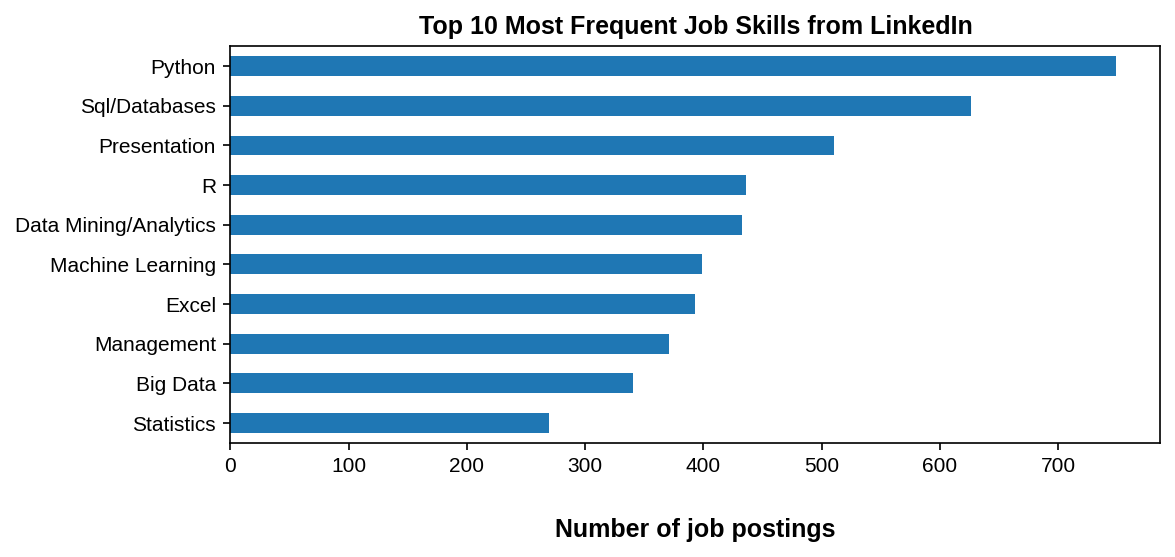

In [10]:
mpl.rcParams['figure.dpi'] = 150
ax = plot1.sort_values(by='count').plot(kind='barh', figsize=(8, 3.5), zorder=1, width=0.5, legend=False)

# Set x-axis label
ax.set_xlabel("Number of job postings", labelpad=20, weight='bold', size=12)

# Set y-axis label
#ax.set_ylabel("Skill", labelpad=20, weight='bold', size=12)

# Plot title
plt.title('Top 10 Most Frequent Job Skills from LinkedIn', weight='bold')

plt.style.use('seaborn')

### Hierarchical Clustering of Job Skills from LinkedIn

In [11]:
cluster_plot = df_linkedin.iloc[:,3:]
cluster_plot

,Excel,Python,R,Java,Scala,C/C++,MATLAB,SAS,SQL/databases,Oracle,SPSS,Stata,Machine Learning,Data Mining/Analytics,NLP,Visualisation,Big Data,AWS Cloud,Probability,Support Vector Machines,Neural Networks,GCP,Jason,xml,Azure,Google Cloud,Mathematics,IBM,Algebra,Statistics,Operations research,DevOps,Git,presentation,management,agile,SDLC,decision making,problem solving,Team building,project_management,leadership,consulting
0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,0,0,0,0,0,1
3,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,0,1,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
908,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
909,0,1,0,1,0,1,0,0,1,0,0,0,1,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0
910,1,1,1,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0
911,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [12]:
# List of skills 
skill_set = cluster_plot.columns.values
skill_set

array(['Excel', 'Python', 'R', 'Java', 'Scala', 'C/C++', 'MATLAB', 'SAS',
       'SQL/databases', 'Oracle', 'SPSS', 'Stata', 'Machine Learning',
       'Data Mining/Analytics', 'NLP', 'Visualisation', 'Big Data',
       'AWS Cloud', 'Probability', 'Support Vector Machines',
       'Neural Networks', 'GCP', 'Jason', 'xml', 'Azure', 'Google Cloud',
       'Mathematics', 'IBM', 'Algebra', 'Statistics',
       'Operations research', 'DevOps', 'Git', 'presentation',
       'management', 'agile', 'SDLC', 'decision making',
       'problem solving', 'Team building', 'project_management',
       'leadership', 'consulting'], dtype=object)

In [13]:
#Need to get the matrix first
#First intitialize the n x n matrix
matrix_dim = len(cluster_plot.columns)
dist_matrix = zeros([matrix_dim , matrix_dim ])

In [14]:
# Copy the dataframe as a matrix
for i in range(matrix_dim):
    for j in range(matrix_dim):
        mask1 = cluster_plot.iloc[:, i] == 1
        mask2 = cluster_plot.iloc[:, j] == 1
        dist_matrix[i,j] = len(cluster_plot[mask1 & mask2])

In [15]:
# normalize the matrix and inspect it
dist_matrix = normalize(dist_matrix )
print('Shape:',dist_matrix .shape)
dist_matrix 

Shape: (43, 43)


array([[0.52956063, 0.37190518, 0.28836126, ..., 0.02560217, 0.07141657,
        0.07276406],
       [0.19074137, 0.51762786, 0.26607039, ..., 0.00069109, 0.02626149,
        0.03731896],
       [0.23219387, 0.41773196, 0.47306788, ..., 0.00108502, 0.00325505,
        0.01519025],
       ...,
       [0.29892547, 0.01573292, 0.01573292, ..., 0.29892547, 0.28319255,
        0.        ],
       [0.35202933, 0.25239839, 0.01992619, ..., 0.11955713, 0.43173408,
        0.2324722 ],
       [0.36008003, 0.36008003, 0.09335408, ..., 0.        , 0.2333852 ,
        0.44009781]])

In [16]:
Y = sch.linkage(dist_matrix, method='weighted')

[]

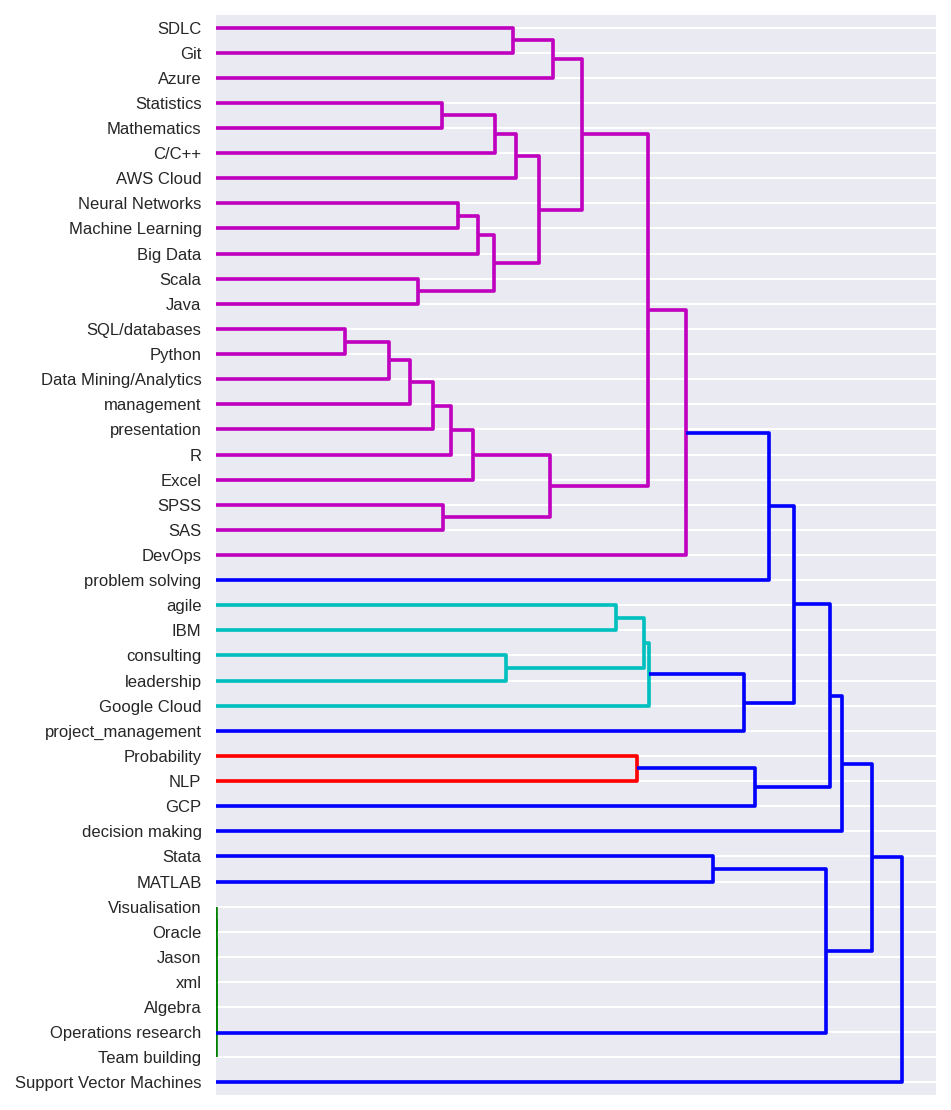

In [17]:
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_axes([0.1,0.1,0.4,0.6])

# Get dendrograms
Z1 = sch.dendrogram(Y, orientation='right')

# Get labels
labels = labels = skill_set[Z1['leaves']]

ax1.set_xticks([])
ax1.set_yticklabels(labels)

plt.plot()

## Kaggle Survey Data Analysis

In [18]:
# import data
# First read and load the data into a Pandas DataFrame
kaggle_df = pd.read_csv('Kaggle_Salary.csv', low_memory=False)
# Inspect the dataset
kaggle_df.head()

,Time from Start to Finish (seconds),Q1,Q2,Q2_OTHER_TEXT,Q3,Q4,Q5,Q5_OTHER_TEXT,Q6,Q7,Q8,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Q9_OTHER_TEXT,Q10,Q11,Q12_Part_1,Q12_Part_2,Q12_Part_3,Q12_Part_4,Q12_Part_5,Q12_Part_6,Q12_Part_7,Q12_Part_8,Q12_Part_9,Q12_Part_10,Q12_Part_11,Q12_Part_12,Q12_OTHER_TEXT,Q13_Part_1,Q13_Part_2,Q13_Part_3,Q13_Part_4,Q13_Part_5,...,Q32_Part_2,Q32_Part_3,Q32_Part_4,Q32_Part_5,Q32_Part_6,Q32_Part_7,Q32_Part_8,Q32_Part_9,Q32_Part_10,Q32_Part_11,Q32_Part_12,Q32_OTHER_TEXT,Q33_Part_1,Q33_Part_2,Q33_Part_3,Q33_Part_4,Q33_Part_5,Q33_Part_6,Q33_Part_7,Q33_Part_8,Q33_Part_9,Q33_Part_10,Q33_Part_11,Q33_Part_12,Q33_OTHER_TEXT,Q34_Part_1,Q34_Part_2,Q34_Part_3,Q34_Part_4,Q34_Part_5,Q34_Part_6,Q34_Part_7,Q34_Part_8,Q34_Part_9,Q34_Part_10,Q34_Part_11,Q34_Part_12,Q34_OTHER_TEXT,Q10_Encoded,Q10_buckets
0,Duration (in seconds),What is your age (# years)?,What is your gender? - Selected Choice,What is your gender? - Prefer to self-describe...,In which country do you currently reside?,What is the highest level of formal education ...,Select the title most similar to your current ...,Select the title most similar to your current ...,What is the size of the company where you are ...,Approximately how many individuals are respons...,Does your current employer incorporate machine...,Select any activities that make up an importan...,Select any activities that make up an importan...,Select any activities that make up an importan...,Select any activities that make up an importan...,Select any activities that make up an importan...,Select any activities that make up an importan...,Select any activities that make up an importan...,Select any activities that make up an importan...,Select any activities that make up an importan...,What is your current yearly compensation (appr...,Approximately how much money have you spent on...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,On which platforms have you begun or completed...,On which platforms have you begun or completed...,On which platforms have you begun or completed...,On which platforms have you begun or completed...,On which platforms have you begun or completed...,...,Which of the following machine learning produc...,Which of the following machine learning produc...,Which of the following machine learning produc...,Which of the following machine learning produc...,Which of the following machine learning produc...,Which of the following machine learning produc...,Which of the following machine learning produc...,Which of the following machine learning produc...,Which of the following machine learning produc...,Which of the following machine learning produc...,Which of the following machine learning produc...,Which of the following machine learning produc...,Which automated machine learning tools (or par...,Which automated machine learning tools (or par...,Which automated machine learning tools (or par...,Which automated machine learning tools (or par...,Which automated machine learning tools (or par...,Which automated machine learning tools (or par...,Which automated machine learning tools (or par...,Which automated machine learning tools (or par...,Which automated machine learning tools (or par...,Which automated machine learning tools (or par...,Which automated machine learning tools (or par...,Which automated machine learning tools (or par...,

In [19]:
# make a list of columns that say "OTHER_TEXT" at the end and then drop them
txt_col = []
for col in kaggle_df.columns:
    if col[-10:] == 'OTHER_TEXT' or col[-4:] == 'TEXT':
        txt_col.append(col)
        
kaggle_df = kaggle_df.drop(columns=txt_col)

In [20]:
# Select only the question of relevance
# First get a list of all the questions
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
header_desc = kaggle_df.iloc[0]
header_desc

Time from Start to Finish (seconds)                                                                                                                                                                                                                           Duration (in seconds)
Q1                                                                                                                                                                                                                                                      What is your age (# years)?
Q2                                                                                                                                                                                                                                           What is your gender? - Selected Choice
Q3                                                                                                                                                                          

In [21]:
pd.reset_option('display.max_colwidth')
pd.reset_option('display.max_rows')

Questions that may be of interest to us include:
- Q13: Which platforms have you begun or completed data science courses? 
- Q14: What is the primary tool that you use at work or school to analyze data?
- Q18: What programming languages do you use on a regular basis?
- Q19: What programming language would you recommend an aspiring data scientist to learn first?
- Q20: What data visualization libraries or tools do you use on a regular basis?
- Q24: Which of the following ML algorithms do you use on a regular basis?
- Q28: Which of the following machine learning frameworks do you use on a regular basis?
- Q29: Which of the following cloud computing platforms do you use on a regular basis?
- Q34: Which of the following relational database products do you use on a regular basis? 

### What programming language would you recommend an aspiring data scientist to learn first?

In [22]:
q_19_subset = kaggle_df[['Q19']]
q_19_subset = q_19_subset.drop(index=0)
q_19_subset = q_19_subset.value_counts().to_frame()

In [23]:
q_19_subset = q_19_subset.rename(columns={0: 'Frequency'}).reset_index()
q_19_subset = q_19_subset.rename(columns={'Q19': 'Programming Language'})
q_19_subset.index = q_19_subset['Programming Language']

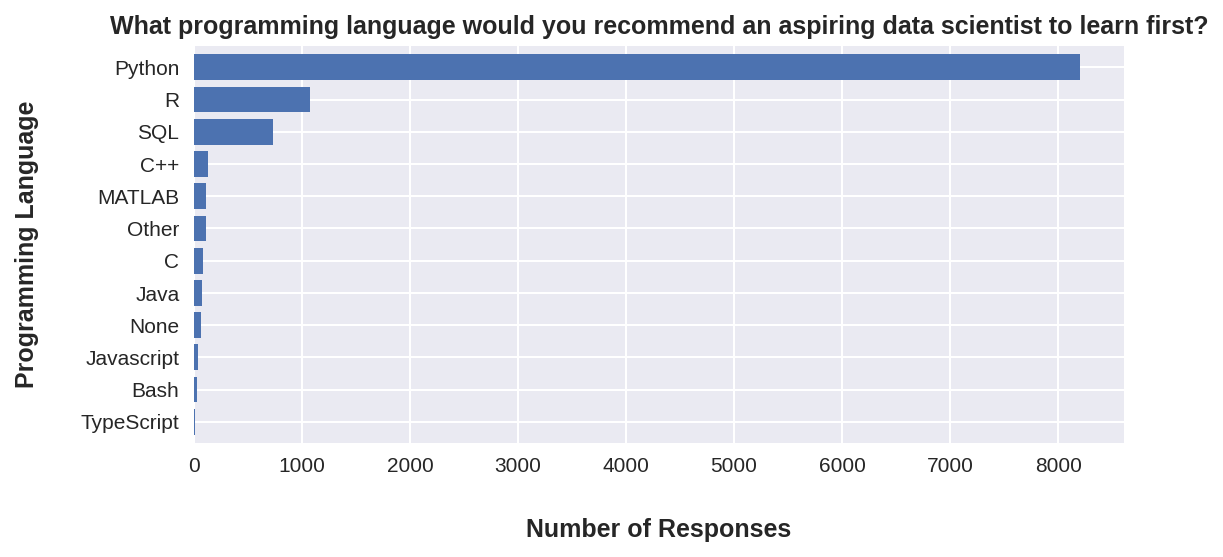

In [24]:
ax = q_19_subset.sort_values(by='Frequency').plot(kind='barh', figsize=(8, 3.5), zorder=1, width=0.8, legend=False)

# Set x-axis label
ax.set_xlabel("Number of Responses", labelpad=20, weight='bold', size=12)

# Set y-axis label
ax.set_ylabel("Programming Language", labelpad=20, weight='bold', size=12)

# Plot title
plt.title('What programming language would you recommend an aspiring data scientist to learn first?', weight='bold')

plt.style.use('seaborn')

Based on this survey, we see that Python is by far, the most recommended language to learn for data scientists, which indicates to us that our program should be focused on teaching Python.

In [25]:
# make a function to create plots for the Kaggle Survey multiple choice response
def kaggle_plot(q_subset, q_num, y_axis_label, title):
    q_col = []
    for col in kaggle_df.columns:
        if col[:3] == q_num:
            q_col.append(col)

    q_subset = kaggle_df[q_col]
    q_subset = q_subset.drop(index=0)

    # Encode this subsection
    q_subset = pd.get_dummies(q_subset)
    col_to_drop = q_subset.columns.to_list()
    q_subset = q_subset.drop(columns=col_to_drop[-2])

    q_subset = q_subset.sum(axis=0).to_frame()

    q_subset = q_subset.sort_values(by=0, ascending=False)
    q_subset = q_subset.reset_index()
    q_subset = q_subset.rename(columns={'index':'X_label', 0:'Response Frequency'})
    new = q_subset['X_label'].str.split("_", n = 4, expand = True) 
    q_subset['X_label'] = new[3]
    q_subset.head()
    q_subset.index = q_subset['X_label']

    ax = q_subset.sort_values(by='Response Frequency').plot(kind='barh', figsize=(8, 3.5), zorder=1, width=0.8, legend=False)

    # Set x-axis label
    ax.set_xlabel("Number of Responses", labelpad=20, weight='bold', size=12)

    # Set y-axis label
    ax.set_ylabel(y_axis_label, labelpad=20, weight='bold', size=12)

    # Plot title
    plt.title(title, weight='bold')

    plt.style.use('seaborn')
    return 

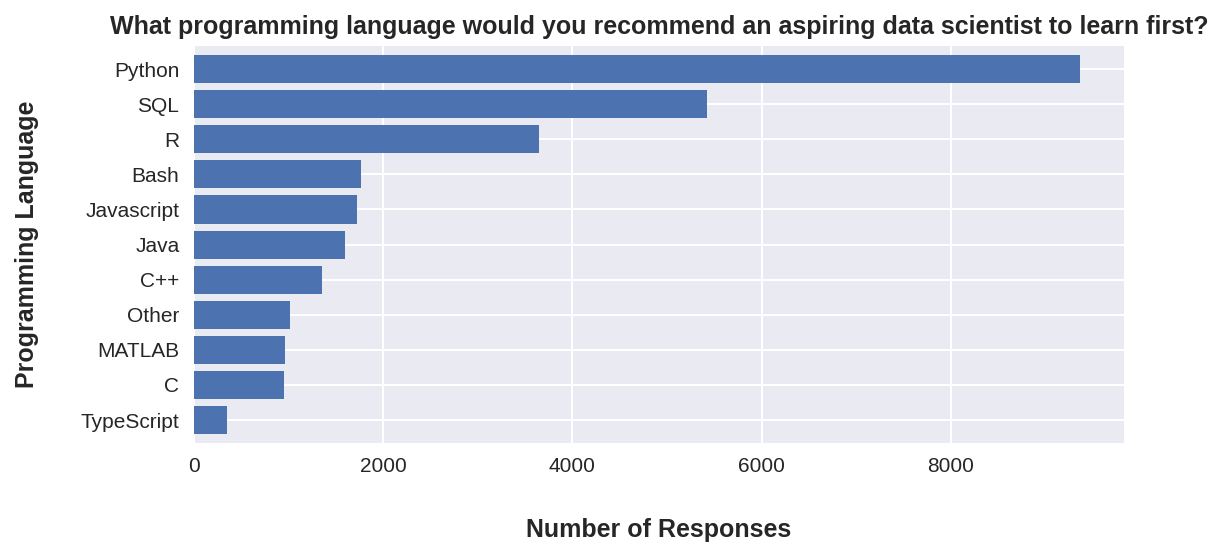

In [26]:
kaggle_plot(kaggle_df, 'Q18', "Programming Language", 
            'What programming language would you recommend an aspiring data scientist to learn first?')

This graph shows that most of the respondents also used Python, however, the second most common language is SQL as opposed to R. 

### ML Framework and Algorithms

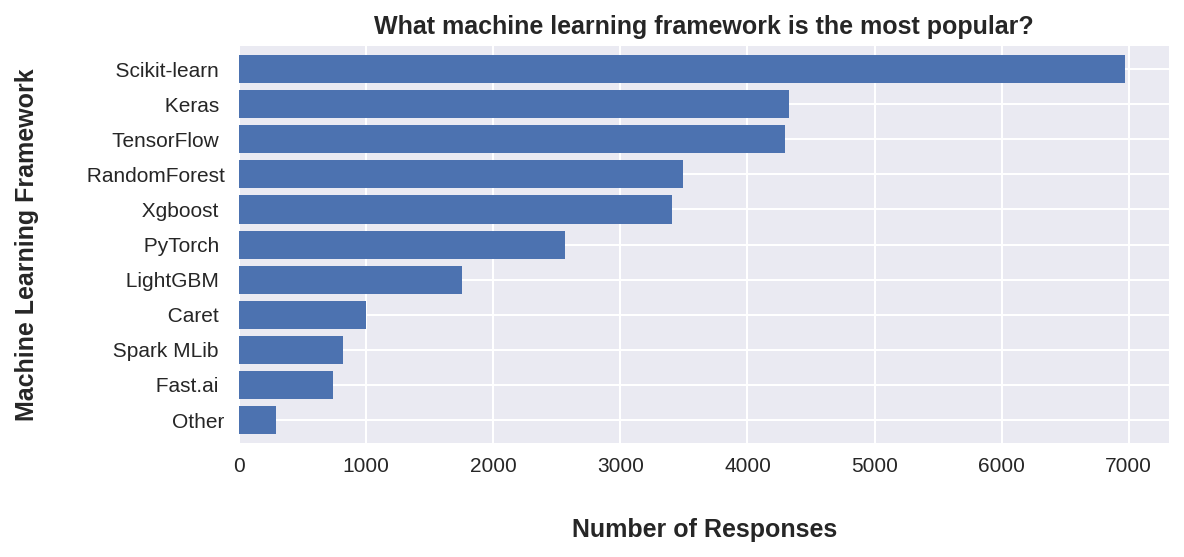

In [27]:
# Most popular frameworks
kaggle_plot(kaggle_df, 'Q28', "Machine Learning Framework", 
            'What machine learning framework is the most popular?')

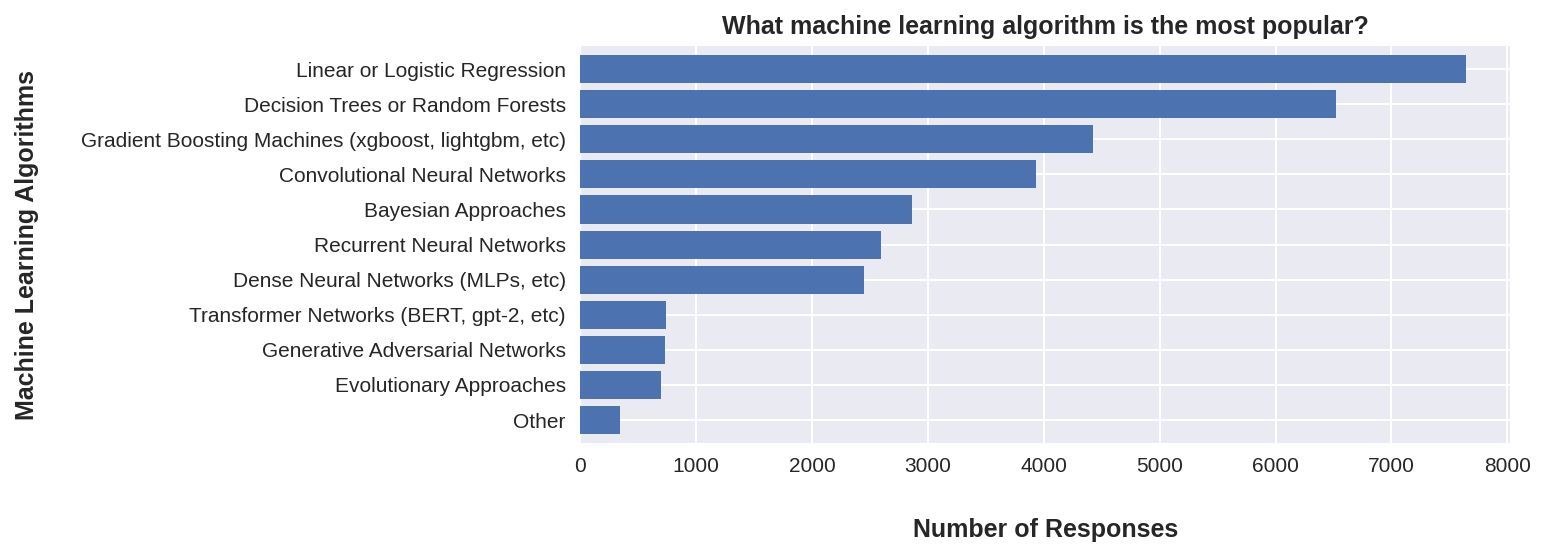

In [28]:
# Most popular algorithms 
kaggle_plot(kaggle_df, 'Q24', "Machine Learning Algorithms", 
            'What machine learning algorithm is the most popular?')

### Cloud Computing

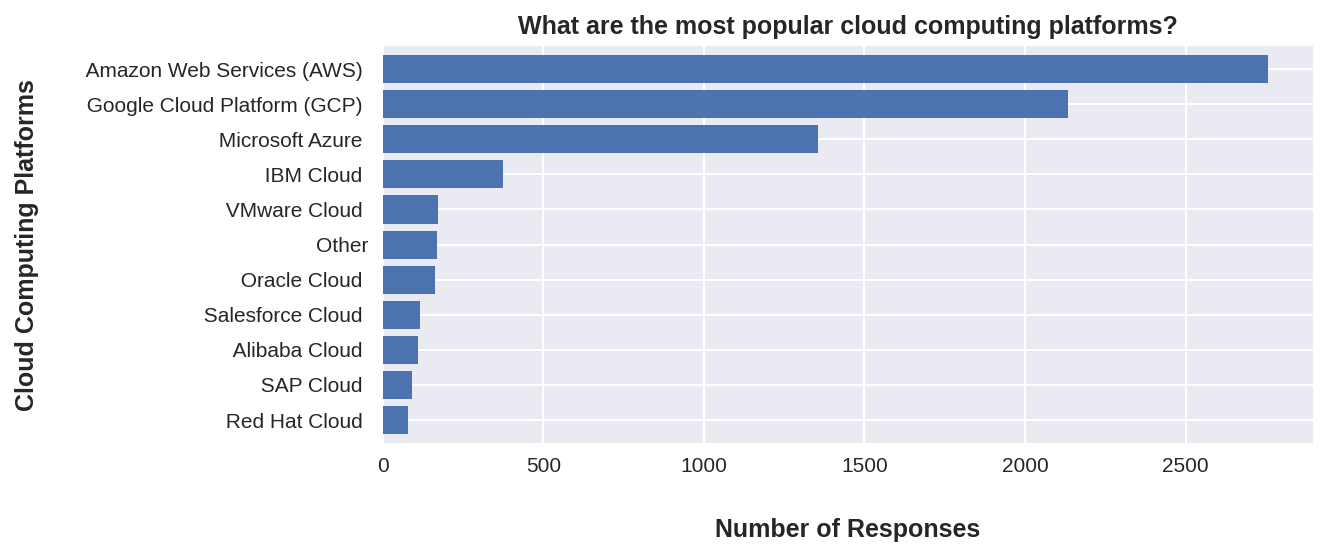

In [29]:
# Most popular cloud platform 
kaggle_plot(kaggle_df, 'Q29', "Cloud Computing Platforms", 
            'What are the most popular cloud computing platforms?')

### Relational Database

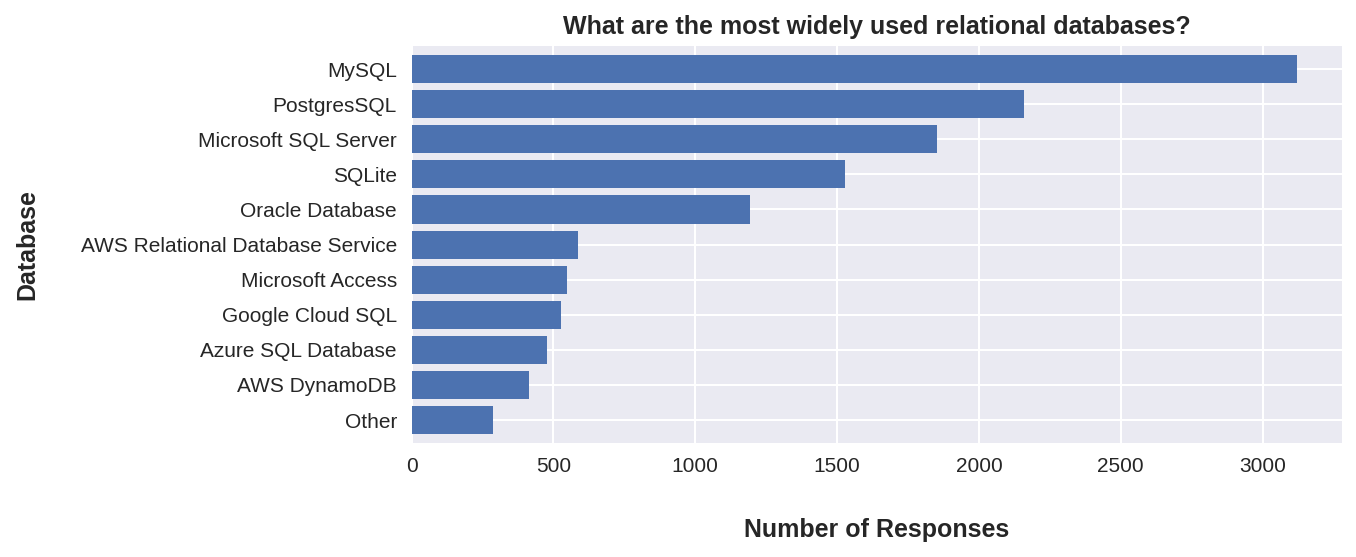

In [30]:
# Most popular relational database
kaggle_plot(kaggle_df, 'Q34', "Database", 
            'What are the most widely used relational databases?')

### Data Visualization Libraries

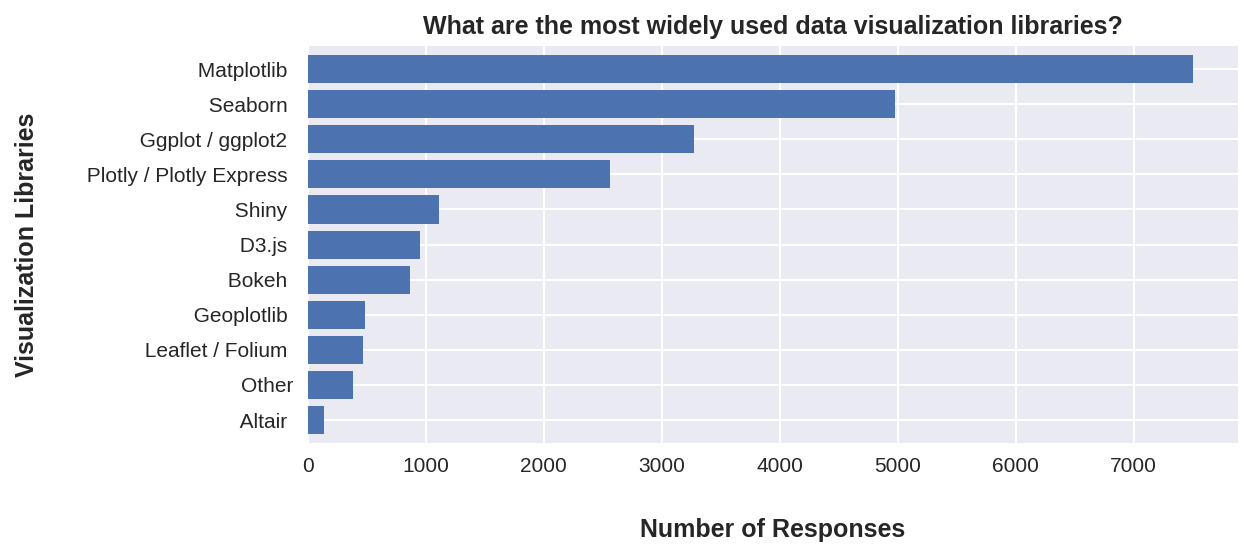

In [31]:
# Most popular visualization libraries
kaggle_plot(kaggle_df, 'Q20', "Visualization Libraries", 
            'What are the most widely used data visualization libraries?')

### Online learning platforms

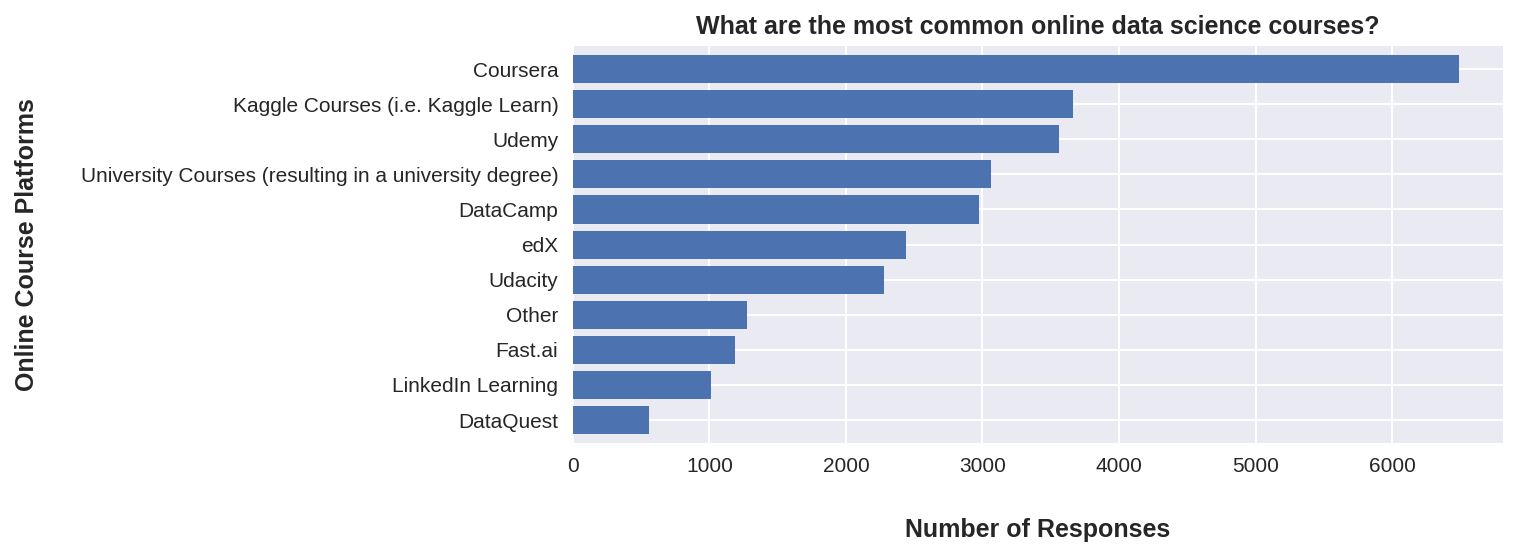

In [32]:
# Most popular online courses
kaggle_plot(kaggle_df, 'Q13', "Online Course Platforms", 
            'What are the most common online data science courses?')

Coursera is a very popular online learning platform so we will be referring to it when creating our program.

### Looking at the most valuable skills based on salary

We will also try to identify the most important skills our program should focus on by looking at which skills are associated with a higher annual salary. This will ensure that our program is teaching students the skills that will help advance their future careers. For this analysis, we will only focus respondents from Canada and the USA because income also varies greatly across different countries and it is likely that most of the graduates of this program will be searching for jobs in either Canada or the USA.

In [33]:
df_salary = kaggle_df

# Take subset of data so only respondents who live in Canada and USA are used in this analysis
df_salary = df_salary[df_salary['Q3'].isin(['United States of America','Canada'])]

We will also remove respondents who are students because we are focusing on those who are now working in this analysis.

In [34]:
df_salary = df_salary[df_salary.Q5 != 'Student']

#inspect final dataframe
print(df_salary.shape[0])
df_salary.head()

2435


,Time from Start to Finish (seconds),Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Q10,Q11,Q12_Part_1,Q12_Part_2,Q12_Part_3,Q12_Part_4,Q12_Part_5,Q12_Part_6,Q12_Part_7,Q12_Part_8,Q12_Part_9,Q12_Part_10,Q12_Part_11,Q12_Part_12,Q13_Part_1,Q13_Part_2,Q13_Part_3,Q13_Part_4,Q13_Part_5,Q13_Part_6,Q13_Part_7,Q13_Part_8,Q13_Part_9,...,Q31_Part_11,Q31_Part_12,Q32_Part_1,Q32_Part_2,Q32_Part_3,Q32_Part_4,Q32_Part_5,Q32_Part_6,Q32_Part_7,Q32_Part_8,Q32_Part_9,Q32_Part_10,Q32_Part_11,Q32_Part_12,Q33_Part_1,Q33_Part_2,Q33_Part_3,Q33_Part_4,Q33_Part_5,Q33_Part_6,Q33_Part_7,Q33_Part_8,Q33_Part_9,Q33_Part_10,Q33_Part_11,Q33_Part_12,Q34_Part_1,Q34_Part_2,Q34_Part_3,Q34_Part_4,Q34_Part_5,Q34_Part_6,Q34_Part_7,Q34_Part_8,Q34_Part_9,Q34_Part_10,Q34_Part_11,Q34_Part_12,Q10_Encoded,Q10_buckets
7,624,22-24,Female,United States of America,Bachelor’s degree,Data Scientist,"> 10,000 employees",20+,"We recently started using ML methods (i.e., mo...",Analyze and understand data to influence produ...,NaN,Build prototypes to explore applying machine l...,Build and/or run a machine learning service th...,NaN,NaN,NaN,NaN,"80,000-89,999",$0 (USD),NaN,Hacker News (https://news.ycombinator.com/),NaN,NaN,NaN,NaN,NaN,"Blogs (Towards Data Science, Medium, Analytics...",Journal Publications (traditional publications...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Udemy,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,"80,000-89,999"
11,372,30-34,Male,United States of America,Master’s degree,Product/Project Manager,"> 10,000 employees",20+,I do not know,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"90,000-99,999",$0 (USD),NaN,Hacker News (https://news.ycombinator.com/),"Reddit (r/machinelearning, r/datascience, etc)","Kaggle (forums, blog, social media, etc)",NaN,NaN,NaN,"Blogs (Towards Data Science, Medium, Analytics...",NaN,NaN,NaN,NaN,Udacity,Coursera,NaN,NaN,DataQuest,Kaggle Courses (i.e. Kaggle Learn),Fast.ai,Udemy,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,"90,000-99,999"
12,485,50-54,Female,United States of America,Master’s degree,Data Analyst,50-249 employees,1-2,We use ML methods for generating insights (but...,Analyze and understand data to influence produ...,Build and/or run the data infrastructure that ...,NaN,NaN,NaN,NaN,NaN,NaN,"125,000-149,999","> $100,000 ($USD)",NaN,NaN,NaN,"Kaggle (forums, blog, social media, etc)",NaN,"YouTube (Cloud AI Adventures, Siraj Raval, etc)","Podcasts (Chai Time Data Science, Linear Digre...","Blogs (Towards Data Science, Medium, Analytics...",NaN,"Slack Communities (ods.ai, kagglenoobs, etc)",NaN,NaN,NaN,Coursera,edX,NaN,NaN,NaN,NaN,Udemy,NaN,...,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,Microsoft SQL Server,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,"125,000-149,9991"
17,979,35-39,Male,United States of America,Bachelor’s degree,Other,250-999 employees,10-14,"We have well established ML methods (i.e., mod...",Analyze and understand data to influence produ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"125,000-149,999",$0 (USD),Twitter (data science influencers),NaN,"Reddit (r/machinelearning, r/datascience, etc)",NaN,NaN,NaN,NaN,"Blogs (Towards Data Science, Medium, Analytics...",Journal Publications (traditional publications...,NaN,NaN,NaN,NaN,Coursera,NaN,DataCamp,NaN,Kaggle Courses (i.e. Kaggle Learn),NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,"125,000-149,9991"
28,402,30-34,Female,United States of America,Master’s degree,Research Scientist,"> 10,000 employees",20+,"We recently started using ML methods (i.e., mo...",Analyze and understand data to influence produ...,

In [35]:
bucket_name = ['$0-9,999',
    '10,000-19,999',
    '20,000-29,999', 
    '30,000-39,999', 
    '40,000-49,999', 
    '50,000-59,999',
    '60,000-69,999',
    '70,000-79,999', 
    '80,000-89,999', 
    '90,000-99,999',
    '100,000-124,999',
    '125,000-149,999',
    '150,000-199,999',
    '200,000-249,999',
    '>250,000-299']

In [36]:
df_salary['Q10_buckets'] = pd.Categorical(df_salary['Q10_buckets'], bucket_name)

Text(0.5, 1.0, '2019 Salary Distribution in Canada and the USA')

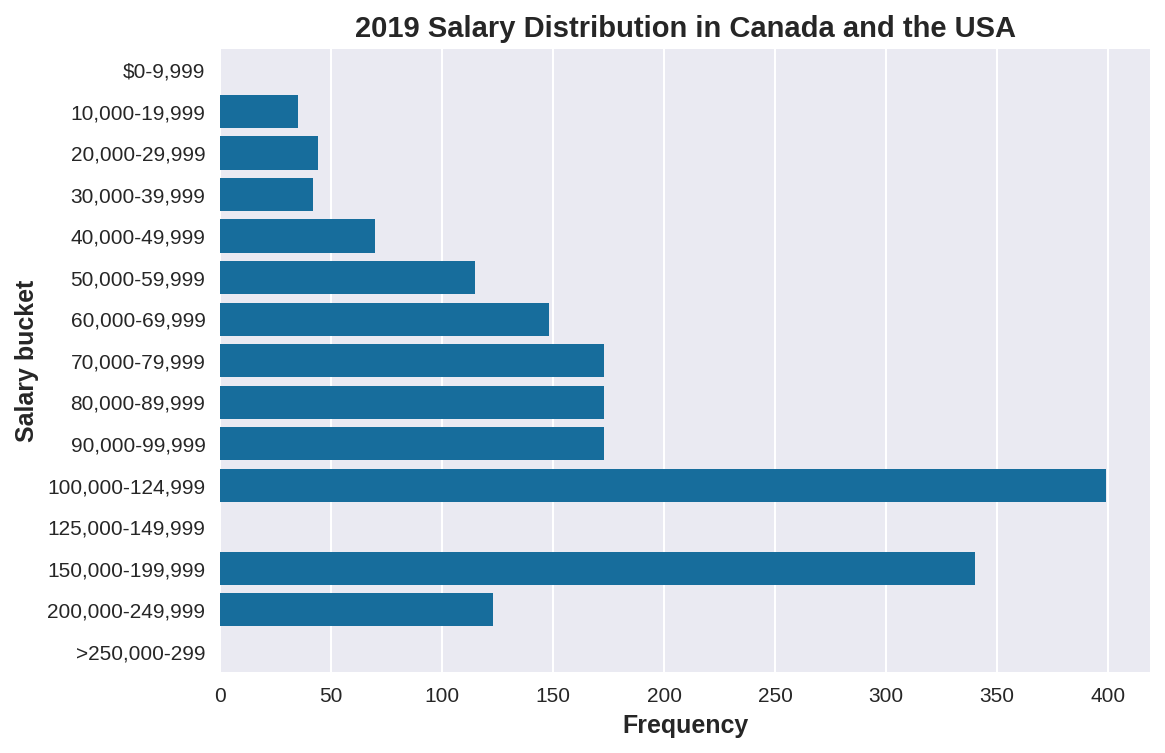

In [37]:
ax=sns.countplot(y='Q10_buckets', data=df_salary, palette=sns.color_palette("colorblind", 1))
ax.set_ylabel('Salary bucket', fontsize=12,weight='bold')
ax.set_xlabel('Frequency', fontsize=12, weight='bold')
ax.set_title('2019 Salary Distribution in Canada and the USA', fontsize=14, weight='bold')

We can now look at what skills are most prevelant amongst individuals who have a high salary. For example, we can look at what programming language is predominantly used. We will use the <b>Kaggle Survey from 2018</b> because it has this question in a single column where respondents can only select one answer. 

In [38]:
# import 2018 survey results 
# First read and load the data into a Pandas DataFrame
kaggle2018_df = pd.read_csv('multipleChoiceResponses.csv', low_memory=False)

In [39]:
#clean the data so that we remove those with missing salary observations and those that 
#did not want to disclose their salaries
kaggle2018_df.dropna(subset=['Q9'],inplace=True) 
kaggle2018_df = kaggle2018_df[kaggle2018_df['Q9'] != "I do not wish to disclose my approximate yearly compensation"]
kaggle2018_df = kaggle2018_df.drop(index=0).reset_index()

In [40]:
kaggle2018_df = kaggle2018_df[kaggle2018_df['Q3'].isin(['United States of America','Canada'])]

In [41]:
kaggle2018_df = kaggle2018_df[kaggle2018_df.Q6 != 'Student'].reset_index()
kaggle2018_df = kaggle2018_df.drop(columns=['level_0', 'index'])
#inspect final dataframe
kaggle2018_df.head()

,Time from Start to Finish (seconds),Q1,Q1_OTHER_TEXT,Q2,Q3,Q4,Q5,Q6,Q6_OTHER_TEXT,Q7,Q7_OTHER_TEXT,Q8,Q9,Q10,Q11_Part_1,Q11_Part_2,Q11_Part_3,Q11_Part_4,Q11_Part_5,Q11_Part_6,Q11_Part_7,Q11_OTHER_TEXT,Q12_MULTIPLE_CHOICE,Q12_Part_1_TEXT,Q12_Part_2_TEXT,Q12_Part_3_TEXT,Q12_Part_4_TEXT,Q12_Part_5_TEXT,Q12_OTHER_TEXT,Q13_Part_1,Q13_Part_2,Q13_Part_3,Q13_Part_4,Q13_Part_5,Q13_Part_6,Q13_Part_7,Q13_Part_8,Q13_Part_9,Q13_Part_10,Q13_Part_11,...,Q46,Q47_Part_1,Q47_Part_2,Q47_Part_3,Q47_Part_4,Q47_Part_5,Q47_Part_6,Q47_Part_7,Q47_Part_8,Q47_Part_9,Q47_Part_10,Q47_Part_11,Q47_Part_12,Q47_Part_13,Q47_Part_14,Q47_Part_15,Q47_Part_16,Q48,Q49_Part_1,Q49_Part_2,Q49_Part_3,Q49_Part_4,Q49_Part_5,Q49_Part_6,Q49_Part_7,Q49_Part_8,Q49_Part_9,Q49_Part_10,Q49_Part_11,Q49_Part_12,Q49_OTHER_TEXT,Q50_Part_1,Q50_Part_2,Q50_Part_3,Q50_Part_4,Q50_Part_5,Q50_Part_6,Q50_Part_7,Q50_Part_8,Q50_OTHER_TEXT
0,718,Female,-1,30-34,United States of America,Master’s degree,"Computer science (software engineering, etc.)",Data Scientist,-1,I am a student,-1,0-1,"0-10,000",I do not know,Analyze and understand data to influence produ...,NaN,NaN,NaN,NaN,NaN,NaN,-1,Local or hosted development environments (RStu...,-1,-1,-1,0,-1,-1,NaN,NaN,NaN,NaN,NaN,NaN,MATLAB,NaN,NaN,NaN,NaN,...,10-20,NaN,Examine feature correlations,Examine feature importances,NaN,NaN,NaN,NaN,Plot predicted vs. actual results,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,I am confident that I can explain the outputs ...,NaN,NaN,NaN,NaN,NaN,NaN,Make sure the code is human-readable,Define all random seeds,NaN,Include a text file describing all dependencies,NaN,NaN,-1,NaN,Too time-consuming,NaN,NaN,NaN,NaN,NaN,NaN,-1
1,823,Male,-1,40-44,United States of America,Master’s degree,Engineering (non-computer focused),Data Scientist,-1,Other,2,5-10,"125-150,000","We recently started using ML methods (i.e., mo...",NaN,Build and/or run a machine learning service th...,NaN,NaN,NaN,NaN,NaN,-1,"Business intelligence software (Salesforce, Ta...",-1,-1,2,-1,-1,-1,NaN,NaN,NaN,NaN,NaN,NaN,MATLAB,Visual Studio,Notepad++,NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None/I do not use these model explanation tech...,NaN,NaN,I am confident that I can understand and expla...,NaN,NaN,NaN,"Share data, code, and environment using contai...",NaN,Make sure the code is well documented,Make sure the code is human-readable,Define all random seeds,NaN,Include a text file describing all dependencies,NaN,NaN,-1,NaN,Too time-consuming,NaN,NaN,Not enough incentives to share my work,NaN,NaN,NaN,-1
2,1917,Male,-1,25-29,United States of America,Bachelor’s degree,Mathematics or statistics,Research Assistant,-1,Academics/Education,-1,1-2,"30-40,000",We are exploring ML methods (and may one day p...,Analyze and understand data to influence produ...,NaN,NaN,Build prototypes to explore applying machine l...,Do research that advances the state of the art...,NaN,NaN,-1,Local or hosted development environments (RStu...,-1,-1,-1,0,-1,-1,Jupyter/IPython,RStudio,NaN,Visual Studio Code,NaN,NaN,MATLAB,Visual Studio,Notepad++,Sublime Text,Vim,...,40-50,NaN,NaN,Examine feature importances,NaN,NaN,Dimensionality reduction techniques,NaN,Plot predicted vs. actual results,NaN,Sensitivity analysis/perturbation importance,NaN,NaN,NaN,NaN,NaN,NaN,"I view ML models as ""black boxes"" but I am con...",Share code on Github or a similar code-sharing...,NaN,NaN,"Share data, code, and environment using contai...",NaN,Make sure the code is well documented,Make sure the code is human-readable,NaN,NaN,Include a text file describing all dependencies,NaN,NaN,-1,NaN,Too time-consuming,NaN,NaN,NaN,NaN,NaN,NaN,-1
3,2150,Male,-1,35-39,United States of America,Some college/university study without earning ...,"Computer science (software engineering, etc.)",Other,4,Military/Security/Defense,-1,5-10,"100-125,000",No (we do not use ML methods),Analyze and understand data to influence produ...,NaN,Build and/or run the data infrastructure that ...,NaN,NaN,NaN,NaN,-1,"Busine

In [42]:
kaggle2018_df['Q9'].unique()

array(['0-10,000', '125-150,000', '30-40,000', '100-125,000',
       '90-100,000', '80-90,000', '10-20,000', '400-500,000', '70-80,000',
       '150-200,000', '60-70,000', '40-50,000', '50-60,000',
       '200-250,000', '20-30,000', '250-300,000', '300-400,000',
       '500,000+'], dtype=object)

In [43]:
bucket_names2018 = ['0-10,000', 
    '20-30,000',
    '30-40,000', 
    '40-50,000', 
    '50-60,000',
    '60-70,000',
    '70-80,000', 
    '80-90,000', 
    '90-100,000',
    '100-125,000',
    '125-150,000',
    '150-200,000',
    '200-250,000',
    '250-300,000',
    '300-400,000',
    '400-500,000',
    '$500,000+']

In [44]:
kaggle2018_df['Q9'] = pd.Categorical(kaggle2018_df['Q9'], bucket_names2018)

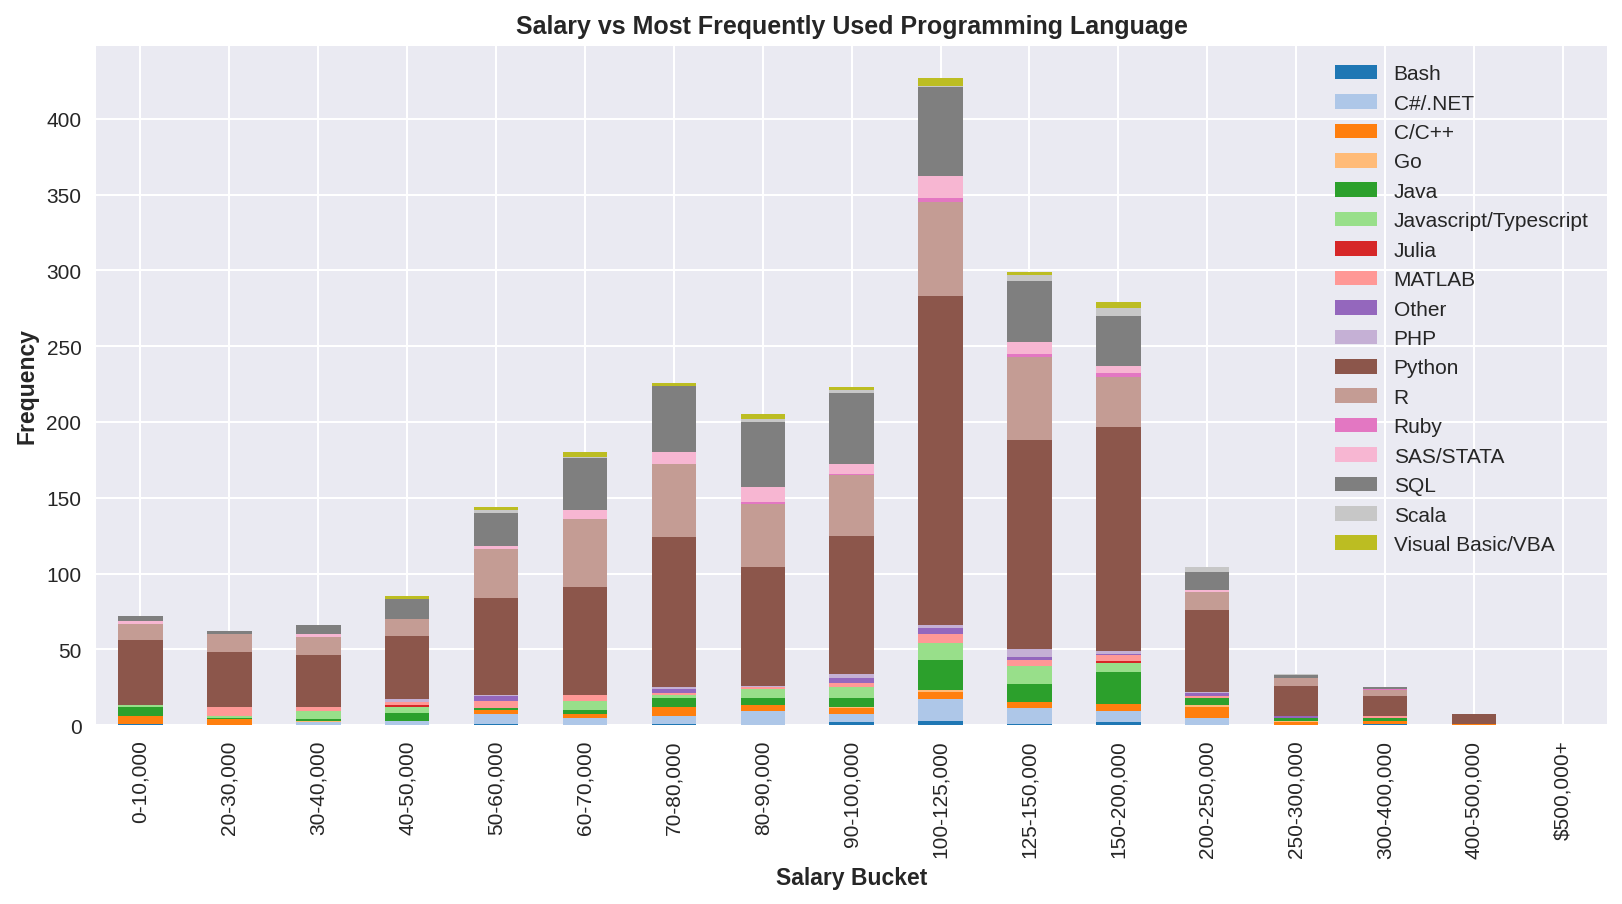

In [45]:
ax = kaggle2018_df.groupby(['Q9','Q17']).size().unstack().plot(kind='bar',stacked=True,figsize=(13, 6), color=sns.color_palette("tab20", 20))
ax.set_xlabel('Salary Bucket', weight='bold')
ax.set_ylabel('Frequency', weight='bold')
ax.set_title('Salary vs Most Frequently Used Programming Language', weight='bold')
ax.legend(loc='best', frameon=False)

From this graph we see that Python is consistently a valuable programming language that should be taught. Other notable languages include R, SQL and MATLAB. Overall, the salary distribution looks similar to the one from 2019, and we can assume that the distribution of programming languages has not changed much since 2018.

For the last part of our analysis of the Kaggle survey, we will use feature selection techniques to determine which skills are the most important for earning a high salary. Here, we will go back to using the 2019 dataset as it is more recent.

In [46]:
def encode_data(df, q_num):
    q_col = []
    for col in df.columns:
        if col[:3] == q_num:
            q_col.append(col)

    q_subset = df[q_col]

    # Encode this subsection
    q_subset = pd.get_dummies(q_subset)
    col_to_drop = q_subset.columns.to_list()
    q_subset = q_subset.drop(columns=col_to_drop[-2])
    return q_subset

In [47]:
df_salary2 = df_salary[['Q10_Encoded', 'Q10_buckets']]

In [48]:
# Encode all the multiple choice questions we are interested in
q_18 = encode_data(df_salary, 'Q18')
q_20 = encode_data(df_salary, 'Q20')
q_24 = encode_data(df_salary, 'Q24')
q_28 = encode_data(df_salary, 'Q28')
q_29 = encode_data(df_salary, 'Q29')
q_34 = encode_data(df_salary, 'Q34')
q_16 = encode_data(df_salary, 'Q16')
q_25 = encode_data(df_salary, 'Q25')
q_31 = encode_data(df_salary, 'Q31')

In [49]:
#join the encoded dataframes into one single dataframe
salaries = df_concat = pd.concat([df_salary['Q10_Encoded'], q_18, q_20, q_24, q_28, q_29, q_34, q_16, q_25, q_31], axis=1)
#inspect the dataframe
salaries.head()

,Q10_Encoded,Q18_Part_1_Python,Q18_Part_2_R,Q18_Part_3_SQL,Q18_Part_4_C,Q18_Part_5_C++,Q18_Part_6_Java,Q18_Part_7_Javascript,Q18_Part_8_TypeScript,Q18_Part_9_Bash,Q18_Part_10_MATLAB,Q18_Part_12_Other,Q20_Part_1_ Ggplot / ggplot2,Q20_Part_2_ Matplotlib,Q20_Part_3_ Altair,Q20_Part_4_ Shiny,Q20_Part_5_ D3.js,Q20_Part_6_ Plotly / Plotly Express,Q20_Part_7_ Bokeh,Q20_Part_8_ Seaborn,Q20_Part_9_ Geoplotlib,Q20_Part_10_ Leaflet / Folium,Q20_Part_12_Other,Q24_Part_1_Linear or Logistic Regression,Q24_Part_2_Decision Trees or Random Forests,"Q24_Part_3_Gradient Boosting Machines (xgboost, lightgbm, etc)",Q24_Part_4_Bayesian Approaches,Q24_Part_5_Evolutionary Approaches,"Q24_Part_6_Dense Neural Networks (MLPs, etc)",Q24_Part_7_Convolutional Neural Networks,Q24_Part_8_Generative Adversarial Networks,Q24_Part_9_Recurrent Neural Networks,"Q24_Part_10_Transformer Networks (BERT, gpt-2, etc)",Q24_Part_12_Other,Q28_Part_1_ Scikit-learn,Q28_Part_2_ TensorFlow,Q28_Part_3_ Keras,Q28_Part_4_ RandomForest,Q28_Part_5_ Xgboost,Q28_Part_6_ PyTorch,...,Q34_Part_1_MySQL,Q34_Part_2_PostgresSQL,Q34_Part_3_SQLite,Q34_Part_4_Microsoft SQL Server,Q34_Part_5_Oracle Database,Q34_Part_6_Microsoft Access,Q34_Part_7_AWS Relational Database Service,Q34_Part_8_AWS DynamoDB,Q34_Part_9_Azure SQL Database,Q34_Part_10_Google Cloud SQL,Q34_Part_12_Other,"Q16_Part_1_Jupyter (JupyterLab, Jupyter Notebooks, etc)",Q16_Part_2_ RStudio,Q16_Part_3_ PyCharm,Q16_Part_4_ Atom,Q16_Part_5_ MATLAB,Q16_Part_6_ Visual Studio / Visual Studio Code,Q16_Part_7_ Spyder,Q16_Part_8_ Vim / Emacs,Q16_Part_9_ Notepad++,Q16_Part_10_ Sublime Text,Q16_Part_12_Other,"Q25_Part_1_Automated data augmentation (e.g. imgaug, albumentations)","Q25_Part_2_Automated feature engineering/selection (e.g. tpot, boruta_py)","Q25_Part_3_Automated model selection (e.g. auto-sklearn, xcessiv)","Q25_Part_4_Automated model architecture searches (e.g. darts, enas)","Q25_Part_5_Automated hyperparameter tuning (e.g. hyperopt, ray.tune)","Q25_Part_6_Automation of full ML pipelines (e.g. Google AutoML, H20 Driverless AI)",Q25_Part_8_Other,Q31_Part_1_Google BigQuery,Q31_Part_2_AWS Redshift,Q31_Part_3_Databricks,Q31_Part_4_AWS Elastic MapReduce,Q31_Part_5_Teradata,Q31_Part_6_Microsoft Analysis Services,Q31_Part_7_Google Cloud Dataflow,Q31_Part_8_AWS Athena,Q31_Part_9_AWS Kinesis,Q31_Part_10_Google Cloud Pub/Sub,Q31_Part_12_Other
7,8.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,9.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12,11.0,1,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17,11.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
28,12.0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,1,1,1,0,1,1,1,1,1,0,1,1,1,1,0,1,...,1,0,0,1,0,1,1,0,1,1,0,1,1,0,0,1,1,1,0,0,0,0,1,0,1,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0


In [50]:
X = salaries.drop(columns=['Q10_Encoded'])
y = salaries['Q10_Encoded']

In [51]:
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(X, y)

sel.get_support()

selected_feat = X.columns[(sel.get_support())]
print(str(len(selected_feat)) + ' features were selected by random forest')

print(selected_feat)

46 features were selected by random forest
Index(['Q18_Part_1_Python', 'Q18_Part_2_R', 'Q18_Part_3_SQL',
       'Q18_Part_6_Java', 'Q18_Part_7_Javascript', 'Q18_Part_9_Bash',
       'Q18_Part_12_Other', 'Q20_Part_1_ Ggplot / ggplot2 ',
       'Q20_Part_2_ Matplotlib ', 'Q20_Part_4_ Shiny ', 'Q20_Part_5_ D3.js ',
       'Q20_Part_6_ Plotly / Plotly Express ', 'Q20_Part_8_ Seaborn ',
       'Q24_Part_1_Linear or Logistic Regression',
       'Q24_Part_2_Decision Trees or Random Forests',
       'Q24_Part_3_Gradient Boosting Machines (xgboost, lightgbm, etc)',
       'Q24_Part_4_Bayesian Approaches',
       'Q24_Part_6_Dense Neural Networks (MLPs, etc)',
       'Q24_Part_7_Convolutional Neural Networks',
       'Q24_Part_9_Recurrent Neural Networks', 'Q28_Part_1_  Scikit-learn ',
       'Q28_Part_2_  TensorFlow ', 'Q28_Part_3_ Keras ',
       'Q28_Part_4_ RandomForest', 'Q28_Part_5_ Xgboost ',
       'Q28_Part_6_ PyTorch ', 'Q28_Part_7_ Caret ',
       'Q29_Part_1_ Google Cloud Platform (G

This indicates which skills are most important for high salary positions. This list similarly supports the results from our previous analysis as similar skills are recurringly present. For example, Python, R and SQL were identified as being important skills again. In terms of algorithms, the most important ones were found to be 

## Analysis of Coursera Data

### Natural Language Processing

In [52]:
!pip install preprocessor

import pandas as pd
pd.set_option('display.max_colwidth', 100)
import numpy as np
import re
import preprocessor as p
import string
from itertools import chain 
import collections 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS
from sklearn.pipeline import Pipeline
from collections import Counter 
from sklearn.cluster import DBSCAN, KMeans

  Created wheel for preprocessor: filename=preprocessor-1.1.3-cp36-none-any.whl size=4477 sha256=dcaeee90ed1be38ab6ce10351631f445d1a231677461e1ccc9a573ba1b389710
  Stored in directory: /root/.cache/pip/wheels/98/c1/a2/21fbcfd80d76576bbf148991a66f00730f541f265c7600000f
Successfully built preprocessor


In [53]:
data = pd.read_csv("courses_ai.csv")
data.columns

Index(['Unnamed: 0', 'Course Names', 'Course Descriptions', 'Course Link'], dtype='object')

In [54]:
# initial data cleaning
data = data[["Course Names", "Course Descriptions"]]
data.shape

(225, 2)

In [55]:
data.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)
data.shape

(191, 2)

In [56]:
#remove punctuations
string.punctuation
def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

data['Course Names'] = data['Course Names'].apply(lambda x: remove_punct(x))
data['Course Descriptions'] = data['Course Descriptions'].apply(lambda x: remove_punct(x))

In [57]:
nltk.download('words')
nltk_words = set(nltk.corpus.words.words())

def remove_non_english(text):
    text = " ".join(w for w in nltk.wordpunct_tokenize(text)
                   if w.lower() in nltk_words or not w.isalpha())
    return text

data['Course Names'] = data['Course Names'].apply(lambda x: remove_non_english(x))
data['Course Descriptions'] = data['Course Descriptions'].apply(lambda x: remove_non_english(x))

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [58]:
#remove extra white spaces
data['Course Names'] = data['Course Names'].str.lower().str.replace('\s\s+', ' ')
data['Course Descriptions'] = data['Course Descriptions'].str.lower().str.replace('\s\s+', ' ')

In [59]:
#inspect data
data.head(5)

,Course Names,Course Descriptions
0,ai engineering professional certificate,artificial intelligence ai is entire the way across leverage data to make to stay competitive ne...
1,mathematics for machine learning specialization,for a lot of higher level in machine learning and data science you find you need to freshen up o...
2,machine learning for all,machine learning often artificial intelligence or ai is one of the most exciting of technology a...
3,data science professional certificate,data science is one of the of the decade and the demand for data who can analyze data and commun...
4,mind and machine specialization,this specialization the ways in which our current understanding of human thinking is both illumi...


We will be generating a Word Cloud for course names and description to visualize what is in the dataset better.

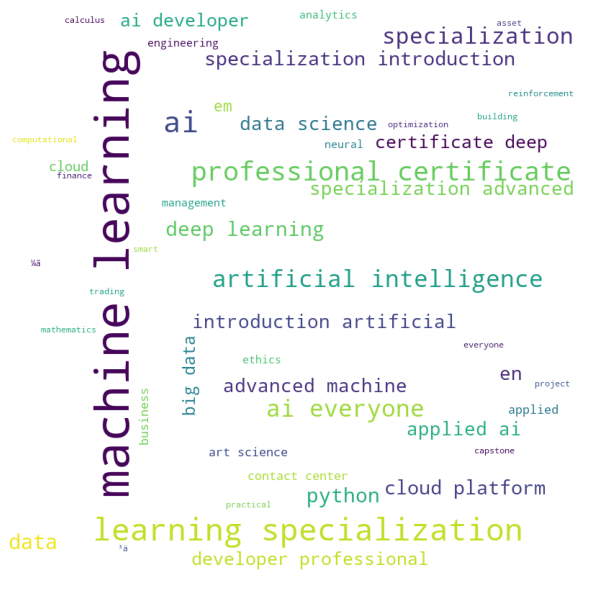

In [60]:
# iterate through the csv file 
stopwords = set(STOPWORDS) 
comment_words = '' 

for word in data["Course Names"]:     
    # typecaste each val to string 
    word = str(word) 
    # split the value 
    tokens = word.split() 

    comment_words += " ".join(tokens)+" "
    
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
    
#plot the WordCloud image                        
plt.figure(figsize = (8,8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

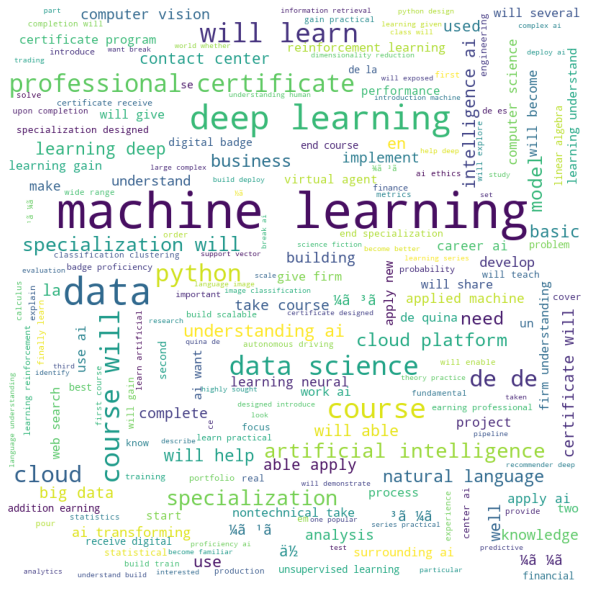

In [61]:
# iterate through the csv file 
stopwords = set(STOPWORDS) 
comment_words = '' 

for word in data["Course Descriptions"]:     
    # typecaste each val to string 
    word = str(word) 
    # split the value 
    tokens = word.split() 

    comment_words += " ".join(tokens)+" "
    
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 

#plot the WordCloud image                        
plt.figure(figsize = (8,8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

### Exploratory Analysis

In [62]:
df_coursera_skill = pd.read_csv('Coureses_Skills.csv')
df_coursera_skill = df_coursera_skill.iloc[:,4:]
df_coursera_skill.head()

,python,data modeling,statistical inference,google cloud platform,technology management,fice,debugging,logistic regression,database management,pandas,artificial intelligence,github,statistical analysis,communication,business intelligence,matplotlib,text mining,numpy,data manipulation,computer science,predictive analytics,reinforcement learning,cloud computing,nosql,innovation,data visualization,decision tree,algorithms,rstudio,data analysis,design thinking,chatbot,problem solving,apache hadoop,regression analysis,applied machine learning,business strategy,computer vision,risk management,multivariable calculus,...,trading,natural language processing,linear regression,neo4j,feature engineering,sql,linear algebra,management,statistics,mongodb,coding,deep learning,c 11,mapreduce,data management,leadership,apache spark,c,r,tensorflow,data processing,predictive modelling,analysis,project,computational neuroscience,data science,team building,graph theory,scikit learn,security,ficial analysis,markov chain monte carlo,classification algorithms,ficial engineering,data architecture,big data,knime,image segmentation,spark,analytics
0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [63]:
freq = df_coursera_skill.sum()
freq.sort_values(ascending=False)
df_freq = freq.to_frame(name="count")
df_freq = df_freq.sort_values(by='count', ascending=False)
top_20_skills = df_freq[:20].index.values

In [64]:
top_20_plot = df_freq[:20]
top_20_plot.index = top_20_plot.index.str.title()
top_20_plot.reset_index()

,index,count
0,Machine Learning,95
1,Deep Learning,47
2,Data Science,45
3,Python,44
4,Artificial Intelligence,39
5,Tensorflow,35
6,Algorithms,23
7,Analysis,22
8,Data Analysis,13
9,Strategy,10


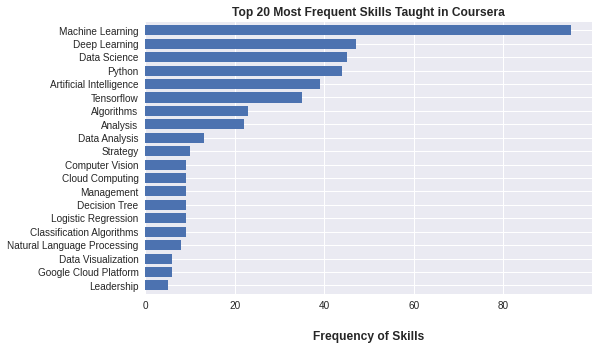

In [65]:
ax2 = top_20_plot.sort_values(by='count').plot(kind='barh', figsize=(8, 5), zorder=1, width=0.75, legend=False)

# Set x-axis label
ax2.set_xlabel("Frequency of Skills", labelpad=20, weight='bold', size=12)

# Set y-axis label
#ax.set_ylabel("Skill", labelpad=20, weight='bold', size=12)

# Plot title
plt.title('Top 20 Most Frequent Skills Taught in Coursera', weight='bold')

plt.style.use('seaborn')

Based on the graph, there appears to be a lot of courses that are focused on deep learning and artifical intelligence (e.g. Tensorflow, Computer Vision). However, we also see the importance of cloud computing, as well as courses that cover the basic skills in data science (e.g. algorithms, analysis, logistic regression, visualization). Therefore, our program curriculum should focus on targeting these skills.

### Hierarchical Clustering of Skills Taught in Coursera

In [66]:
cluster_cousera = df_coursera_skill

# List of skills 
coursera_skill = cluster_cousera.columns.values
coursera_skill

array(['python', 'data modeling', 'statistical inference',
       'google cloud platform', 'technology management', 'fice',
       'debugging', 'logistic regression', 'database management',
       'pandas', 'artificial intelligence', 'github',
       'statistical analysis', 'communication', 'business intelligence',
       'matplotlib', 'text mining', 'numpy', 'data manipulation',
       'computer science', 'predictive analytics',
       'reinforcement learning', 'cloud computing', 'nosql', 'innovation',
       'data visualization', 'decision tree', 'algorithms', 'rstudio',
       'data analysis', 'design thinking', 'chatbot', 'problem solving',
       'apache hadoop', 'regression analysis', 'applied machine learning',
       'business strategy', 'computer vision', 'risk management',
       'multivariable calculus', 'machine learning', 'business analysis',
       'database', 'strategy', 'random forest', 'trading',
       'natural language processing', 'linear regression', 'neo4j',
     

In [67]:
#Need to get the matrix first
#First intitialize the n x n matrix
matrix_dim = len(cluster_cousera.columns)
dist_matrix = zeros([matrix_dim , matrix_dim ])

[]

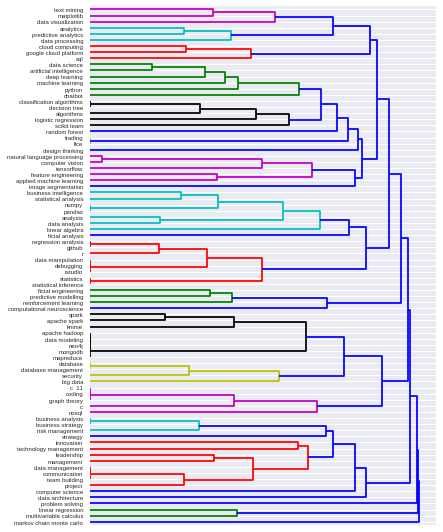

In [68]:
# Copy the dataframe as a matrix
for i in range(matrix_dim):
    for j in range(matrix_dim):
        mask1 = cluster_cousera.iloc[:, i] == 1
        mask2 = cluster_cousera.iloc[:, j] == 1
        dist_matrix[i,j] = len(cluster_cousera[mask1 & mask2])
        
# normalize the matrix
dist_matrix = normalize(dist_matrix )

Y = sch.linkage(dist_matrix, method='weighted')

fig = plt.figure(figsize=(12,12))
ax1 = fig.add_axes([0.1,0.1,0.4,0.6])

# Get dendrograms
Z1 = sch.dendrogram(Y, orientation='right')

# Get labels
labels = labels = coursera_skill[Z1['leaves']]

ax1.set_xticks([])
ax1.set_yticklabels(labels)

plt.plot()

This dendrogram shows a bit more details compared to the previous one, but provides the same insight and findings. For instance, technical skills such as "data science", "artificial intelligence", "deep learning", "machine learning" and "python" are grouped together, where as "innovation", "leadership", "management", "communication", "team building" and "project" are grouped in a different cluster. However, this indicates to us that in order to be a well-rounded job applicant, both types of skills should be fostered in a Master's program. 

# Part 3 - EdTech Solution

In [69]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from google.colab import files
import io
import collections
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.base import BaseEstimator, TransformerMixin
import re
import string


## Data from LinkedIn user profiles</br>
The dataframe contains LinkedIn user profies and their associated skills. Skills are in columns wihtout any sorting. In order to use this data, we'll have to sort the skills so that each coloumn is 1-hot encoded for a specific skill. For example, 'Data Analysis' will be one column title and users who poses this skill will have 1 in this coloumn and 0 otherwise.

In [70]:
profiles_df = pd.read_csv(io.BytesIO(uploader['user_name_list_1.csv']),encoding='utf-8')
profiles_df

,Job1,Job2,Job3,Job4,Experience,URL,school,Last degree,Major,Skills 1,Skills 2,Skills 3,Skills 4,Skills 5,Skills 6,Skills 7,Skills 8,Skills 9,Skills 10,Skills 11,Skills 12,Skills 13,Skills 14,Skills 15,Skills 16,Skills 17,Skills 18,Skills 19,Skills 20,Skills 21,Skills 22,Skills 23,Skills 24,Skills 25,Skills 26,Skills 27,Skills 28,Skills 29,Skills 30,Skills 31,Skills 32,Skills 33,Skills 34,Skills 35,Skills 36,Skills 37,Skills 38,Skills 39,Skills 40
0,Sr. Data Scientist,Data Scientist,Data Analyst,,10.750000,https://ca.linkedin.com/in/susanli,Stanford University School of Engineering,Statistics with R Specialization,Statistics,Social Media,Marketing,Tourism,Social Media Marketing,Data Analysis,Business Strategy,Business Development,Online Advertising,Data Science,Machine Learning,Hotels,Online Marketing,Data Mining,New Business Development,Email Marketing,Data Visualization,SEM,Web Analytics,Strategic Planning,Digital Strategy,SEO,PPC,Search Engine Optimization (SEO),Search Engine Marketing (SEM),machine learning,Pay Per Click (PPC),Python,Python (Programming Language),R,Tableau,Google Analytics,python,Transact-SQL (T-SQL),Hospitality,Marketing Communications,Hospitality Industry,Natural Language Processing (NLP),NaN,NaN,NaN
1,Data Analytics Instructor,Data Scientist,Title\nData Science and Analytics Manager,,2.833333,https://ca.linkedin.com/in/andresadeandrade,Ryerson University,Bachelor's degree,Statistics,Data Mining,SEO,SAS programming,Big Data,Digital Marketing,Web Analytics,SEM,E-commerce,Banking,Financial Analysis,Facebook Marketing,Data Analysis,SAS/SQL,Econometrics,Social Media Marketing,Online Marketing,Machine Learning,R,Google Analytics,Microsoft Excel,Databases,VBA,Microsoft Office,Python,Google Adwords,PHP,SQL,English,Time Series Analysis,Stochastic Modeling,Predictive Modeling,Omniture,Facebook API,Cluster Analysis,Categorical Data Analysis,Web Tracking,Omn,NaN,NaN,NaN
2,"Data Scientist, Machine Learning Model Validation",Artificial Intelligence Fellow,Computer-Aided Engineering (CAE) Co-op,,2.000000,https://ca.linkedin.com/in/sanjifr3,University of Toronto,Bachelor of Applied Science (BASc),Mechanical Engineering,Engineering,Data Analysis,Data Mining,Big Data,Data Visualization,Data Structures,Algorithms,Artificial Intelligence (AI),Finite Element Analysis (FEA),System Architecture,Mechanical Engineering,Software Engineering,Object-Oriented Programming (OOP),Software Architecture,Python,C++,git,Microsoft Office,AutoCAD,Java,Matlab,Microsoft Excel,PyTorch,SolidWorks,Keras,TensorFlow,Visual Basic for Applications (VBA),Amazon Web Services (AWS),Google Cloud Platform (GCP),Arduino,Github,Linux,Bash,Flask,Recurrent Neural Networks (RNN),Teamwork,Customer Service,Communication,Robot Operating System (ROS),Scikit-Learn
3,Data Scientist,Data Analyst,Summer Intern,,1.416667,https://ca.linkedin.com/in/priscilla-jiayan-zhang-219b0996,University of Toronto,Chemical engineering (Computer processing control),GPA (3.8/4.0),Data Analysis,Financial Modeling,Python (Programming Language),SQL,Tableau,MATLAB,Hive,Apache Spark,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Data Scientist,Senior Analyst Data Science,,,1.833333,https://ca.linkedin.com/in/kennethjpreston,Udacity,Certification,Management of Enterprise Data Analytics,Statistics,Survey Design,Research,Analytics,Segmentation,Project Management,Analysis,Report Writing,Data Mining,Research and Development (R&D),Software Development,Marketing Research,SPSS,R,Python,Visual Studio,R Shiny,SQL,AWS SageMaker,Focus Groups,Advertising Research,Copy Testing,CHAID,CART,Logistic Regression,Regression Analysis,Factor Analysis,Conjoint Analysis,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
457,Data Scientis

### Data cleanup</br>
   

In [71]:
# Function to clean up skills by removing punctuation and making words lower cased
def remove_punctuation(input_text):
    # Make translation table
    punct = string.punctuation
    trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
    return input_text.translate(trantab)

def to_lower(input_text):
    return input_text.lower().strip()

def remove_brackets(input_text):
    return re.sub("[\(\[].*?[\)\]]", "", input_text)
  
def remove_words(input_text):
    return input_text.replace('microsoft','').replace('adobe','').replace('programming','').replace('nan','').strip()
    
def CleanText(x_list):
  x_clean=[]
  for x in x_list:
    x = remove_brackets(x)
    x = remove_punctuation(x)
    x = to_lower(x)
    x = remove_words(x)
    x_clean.append(x)
  return x_clean


In [72]:
# Identify all unique skills mentioned in the data set
def unique_skills(data,start):
  skill_set = set([])
  skill_columns=data.columns[start:-1]
  for skill in skill_columns:
    new_set = set(CleanText(list(data[skill].unique().astype(str))))
    skill_set = skill_set | new_set
  skill_set = list(skill_set)
  a=skill_set.pop(0)
  print(a)
  return skill_set

In [73]:
skill_set = unique_skills(profiles_df,9)

In [74]:
# Create a coloumn that contains all the skills for a user in continious string
def merger(data,start):
  merge_list=[]
  for i in range(data.shape[0]):
    merge_list.append(' '.join(set(CleanText(list(data.iloc[i,start:-1].astype(str))))).strip())

  data['Skills']=merge_list

  return data

In [75]:
profiles_df = merger(profiles_df,9)

In [76]:
# Find a specific skill in a user by comparing the continious 'Skills' string with specific skill in 'skill_set'
def findWholeWord(w):
    return re.compile(r'\b({0})\b'.format(w), flags=re.IGNORECASE).search
def find_skills(data,skill_set):
  for skill in skill_set:
    data[skill] = 0
  for i in range(data.shape[0]):
    for skill in skill_set:
      if findWholeWord(skill)(data['Skills'].iloc[i]):
        data[skill].iloc[i] = 1
  return data

In [77]:
profiles_df = find_skills(profiles_df,skill_set)

In [78]:
print('Numebr of unique skills extracted from user profiles: {}'.format(len(skill_set)))

Numebr of unique skills extracted from user profiles: 2050


## Coursera data science course list</br>

We'll read in a data set of coursera courses and identify skills associated with each course. The skill sorting will follow the same procedure used for LinkedIn user profiles.


In [ ]:
uploader2 = files.upload()

Saving courses_ai_out.csv to courses_ai_out.csv


In [80]:
courses_df = pd.read_csv('courses_ai_out.csv')

In [81]:
courses_df

,Index,Course Name,Description,URL,Skills 1,Skills 2,Skills 3,Skills 4,Skills 5,Skills 6,Skills 7,Skills 8,Skills 9,Skills 10
0,0,IBM AI Engineering Professional Certificate,"Artificial intelligence (AI) is revolutionizing entire industries, changing the way companies ac...",https://www.coursera.org/professional-certificates/ai-engineer,Data Science,Artificial Neural Network,Artificial Intelligence (AI),Machine Learning,Python Programming,Big Data,Spark,NaN,NaN,NaN
1,1,Mathematics for Machine Learning Specialization,"For a lot of higher level courses in Machine Learning and Data Science, you find you need to fre...",https://www.coursera.org/specializations/mathematics-machine-learning,Eigenvalues And Eigenvectors,Principal Component Analysis (PCA),Multivariable Calculus,Linear Algebra,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Machine Learning for All,"Machine Learning, often called Artificial Intelligence or AI, is one of the most exciting areas ...",https://www.coursera.org/learn/uol-machine-learning-for-all,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,IBM Data Science Professional Certificate,"Data science is one of the hottest professions of the decade, and the demand for data scientists...",https://www.coursera.org/professional-certificates/ibm-data-science,Data Science,Statistical Analysis,Machine Learning,Python Programming,Business Intelligence,Data Analysis,Pandas,Numpy,NaN,NaN
4,4,Mind and Machine Specialization,This specialization examines the ways in which our current understanding of human thinking is bo...,https://www.coursera.org/specializations/mind-machine,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,220,Introduction to Clinical Data,This course introduces you to a framework for successful and ethical medical data mining. We wil...,https://www.coursera.org/learn/introduction-clinical-data,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
221,221,Introduction to Portfolio Construction and Analysis with Python,The practice of investment management has been transformed in recent years by computational meth...,https://www.coursera.org/learn/introduction-portfolio-construction-python,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
222,222,"Applied Plotting, Charting & Data Representation in Python","This course will introduce the learner to information visualization basics, with a focus on repo...",https://www.coursera.org/learn/python-plotting,Python Programming,Data Virtualization,Data Visualization (DataViz),Matplotlib,NaN,NaN,NaN,NaN,NaN,NaN
223,223,Python Data Products for Predictive Analytics Specialization,"Python data products are powering the AI revolution. Top companies like Google, Facebook, and Ne...",https://www.coursera.org/specializations/python-data-products-for-predictive-analytics,Machine Learning,Python Programming,Predictive Analytics,Data Processing,Data Visualization (DataViz),Python Libraries,NaN,NaN,NaN,NaN


In [82]:
course_skills = unique_skills(courses_df,4)
courses_df = merger(courses_df,4)
courses_df = find_skills(courses_df,course_skills)


##Data exploration

We'll plot a distribution of total work experience of user profiles in our dataset

Average work expreriece of the profiles = 6.897 years


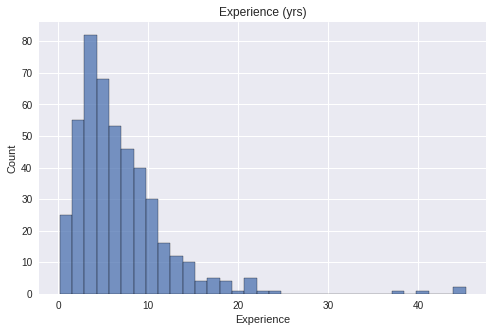

In [83]:
fig,ax = plt.subplots(1,1,figsize = (8,5))
exp_dist=sns.histplot(data= profiles_df,x='Experience',ax=ax)
ax.set_title('Experience (yrs)')

print('Average work expreriece of the profiles = {0} years'.format(round(profiles_df['Experience'].mean(),3)))

Let's look at what skills are most common  amongst users. Here we'll plot the top 25 skills amongst the profiles

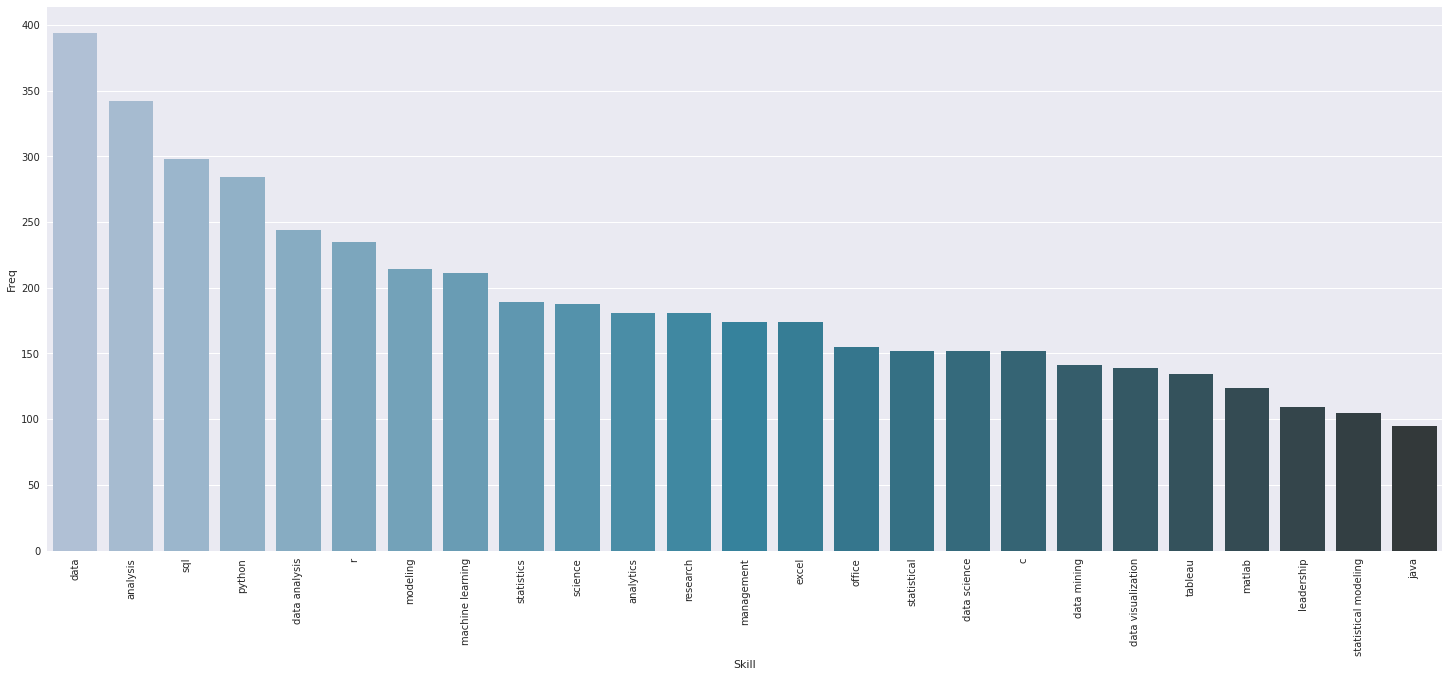

In [84]:
skill_freq=dict(zip(skill_set,np.asarray(profiles_df[skill_set].sum())))
skill_counter = collections.Counter(skill_freq)
skill_counter_df = pd.DataFrame(skill_counter.most_common(25), columns = ['Skill', 'Freq'])

fig, ax = plt.subplots(figsize=(25, 10))
bar_freq_word = sns.barplot(x="Skill", y="Freq", data=skill_counter_df, palette="PuBuGn_d", ax=ax)
sns.set(font_scale = 0.5)
plt.xticks(rotation=90)
plt.show();

We'll only retain the top 150 skills out of a total of 2000+ skills in the current set

In [85]:
skills_orderd=skill_counter.most_common()
least_common = skills_orderd[200:-1]
least_common = [skill[0] for skill in least_common]
profiles_df=profiles_df.drop(labels=least_common,axis=1)

In [86]:
profiles_df

,Job1,Job2,Job3,Job4,Experience,URL,school,Last degree,Major,Skills 1,Skills 2,Skills 3,Skills 4,Skills 5,Skills 6,Skills 7,Skills 8,Skills 9,Skills 10,Skills 11,Skills 12,Skills 13,Skills 14,Skills 15,Skills 16,Skills 17,Skills 18,Skills 19,Skills 20,Skills 21,Skills 22,Skills 23,Skills 24,Skills 25,Skills 26,Skills 27,Skills 28,Skills 29,Skills 30,Skills 31,...,google analytics,sas,project planning,html5,power bi,sql,keras,cloud computing,matlab,mathematical modeling,economics,numpy,experimental design,logistic regression,object oriented,machine learning algorithms,data analytics,forecasting,mongodb,simulations,web scraping,github,data modeling,databases,policy,data,neural networks,strategic planning,numerical analysis,entrepreneurship,pandas,computer vision,sales,google cloud,mathematics,data wrangling,customer service,cascading style sheets,technology,iso 13485
0,Sr. Data Scientist,Data Scientist,Data Analyst,,10.750000,https://ca.linkedin.com/in/susanli,Stanford University School of Engineering,Statistics with R Specialization,Statistics,Social Media,Marketing,Tourism,Social Media Marketing,Data Analysis,Business Strategy,Business Development,Online Advertising,Data Science,Machine Learning,Hotels,Online Marketing,Data Mining,New Business Development,Email Marketing,Data Visualization,SEM,Web Analytics,Strategic Planning,Digital Strategy,SEO,PPC,Search Engine Optimization (SEO),Search Engine Marketing (SEM),machine learning,Pay Per Click (PPC),Python,Python (Programming Language),R,Tableau,Google Analytics,...,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,Data Analytics Instructor,Data Scientist,Title\nData Science and Analytics Manager,,2.833333,https://ca.linkedin.com/in/andresadeandrade,Ryerson University,Bachelor's degree,Statistics,Data Mining,SEO,SAS programming,Big Data,Digital Marketing,Web Analytics,SEM,E-commerce,Banking,Financial Analysis,Facebook Marketing,Data Analysis,SAS/SQL,Econometrics,Social Media Marketing,Online Marketing,Machine Learning,R,Google Analytics,Microsoft Excel,Databases,VBA,Microsoft Office,Python,Google Adwords,PHP,SQL,English,Time Series Analysis,Stochastic Modeling,Predictive Modeling,...,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"Data Scientist, Machine Learning Model Validation",Artificial Intelligence Fellow,Computer-Aided Engineering (CAE) Co-op,,2.000000,https://ca.linkedin.com/in/sanjifr3,University of Toronto,Bachelor of Applied Science (BASc),Mechanical Engineering,Engineering,Data Analysis,Data Mining,Big Data,Data Visualization,Data Structures,Algorithms,Artificial Intelligence (AI),Finite Element Analysis (FEA),System Architecture,Mechanical Engineering,Software Engineering,Object-Oriented Programming (OOP),Software Architecture,Python,C++,git,Microsoft Office,AutoCAD,Java,Matlab,Microsoft Excel,PyTorch,SolidWorks,Keras,TensorFlow,Visual Basic for Applications (VBA),Amazon Web Services (AWS),Google Cloud Platform (GCP),Arduino,Github,...,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0
3,Data Scientist,Data Analyst,Summer Intern,,1.416667,https://ca.linkedin.com/in/priscilla-jiayan-zhang-219b0996,University of Toronto,Chemical engineering (Computer processing control),GPA (3.8/4.0),Data Analysis,Financial Modeling,Python (Programming Language),SQL,Tableau,MATLAB,Hive,Apache Spark,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Data Scientist,Senior Analyst Data Science,,,1.833333,https://ca.linkedin.com/in/kennethjpreston,Udacity,Certification,Management of Enterprise Data Analytics,Statistics,Survey Design,Research,Analytics,Segmentation,Project Management,Analysis,Report Writing,Data Mining,Research and Development (R&D),Software Development,Marketing Research,SPSS,R,Python,Visual Studio,R Shiny,SQL,AWS SageMaker,Focus Groups,Advertising Res

Each profile will be given a score based on the number of skills they posses. 

count    462.000000
mean      22.365801
std        9.733229
min        1.000000
25%       15.000000
50%       22.000000
75%       30.000000
max       51.000000
Name: Score, dtype: float64


Text(0.5, 1.0, 'Profile Scores')

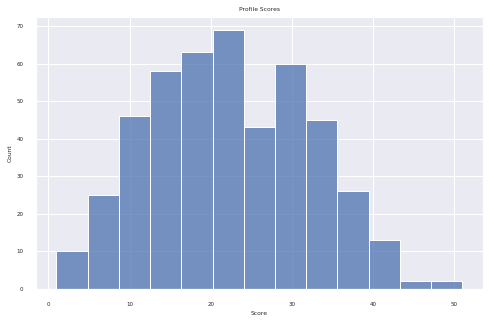

In [87]:
scores=profiles_df.iloc[:,50:-1].sum(axis=1)
profiles_df['Score'] = scores
print(profiles_df['Score'].describe())
fig,ax = plt.subplots(1,1,figsize = (8,5))
exp_dist=sns.histplot(data= profiles_df,x='Score',ax=ax)
sns.set(font_scale = 0.5)
ax.set_title('Profile Scores')

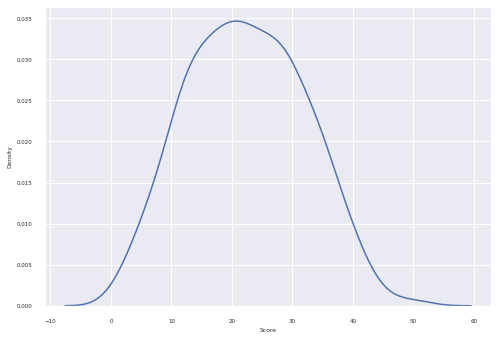

In [88]:
sns.kdeplot(data=profiles_df,x='Score')

We'll sort experience into buckets as follows:

In [89]:
profiles_df['Experience_bucket']=pd.cut(x=profiles_df['Experience'],bins=[0,2,4,6,8,10,15,20,75],labels=['<2','2-4','4-6','6-8','8-10','10-15','15-20','20+'])

Text(0.5, 1.0, 'Experience (yrs)')

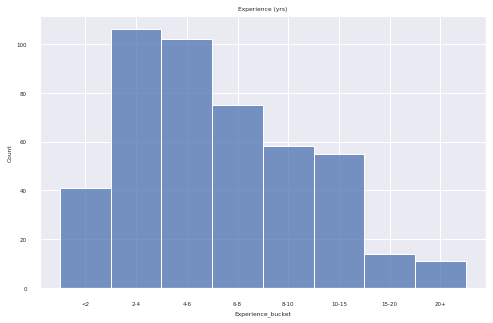

In [90]:
fig,ax = plt.subplots(1,1,figsize = (8,5))
exp_dist=sns.histplot(data= profiles_df,x='Experience_bucket',ax=ax)
ax.set_title('Experience (yrs)')

In [91]:
profiles_df.groupby('Experience_bucket')['Score'].describe()

,count,mean,std,min,25%,50%,75%,max
Experience_bucket,,,,,,,,
<2,41.0,22.902439,9.219015,6.0,17.00,23.0,31.0,41.0
2-4,106.0,23.500000,9.808888,1.0,17.00,22.0,30.0,49.0
4-6,102.0,22.333333,10.310365,1.0,13.50,22.0,30.0,46.0
6-8,75.0,21.373333,10.328095,2.0,13.50,21.0,29.5,42.0
8-10,58.0,21.879310,9.294551,4.0,15.00,22.5,26.0,51.0
10-15,55.0,21.800000,9.167980,2.0,14.50,23.0,28.5,44.0
15-20,14.0,19.857143,8.084716,10.0,14.25,18.0,26.0,36.0
20+,11.0,25.090909,8.971673,9.0,19.50,27.0,32.0,35.0


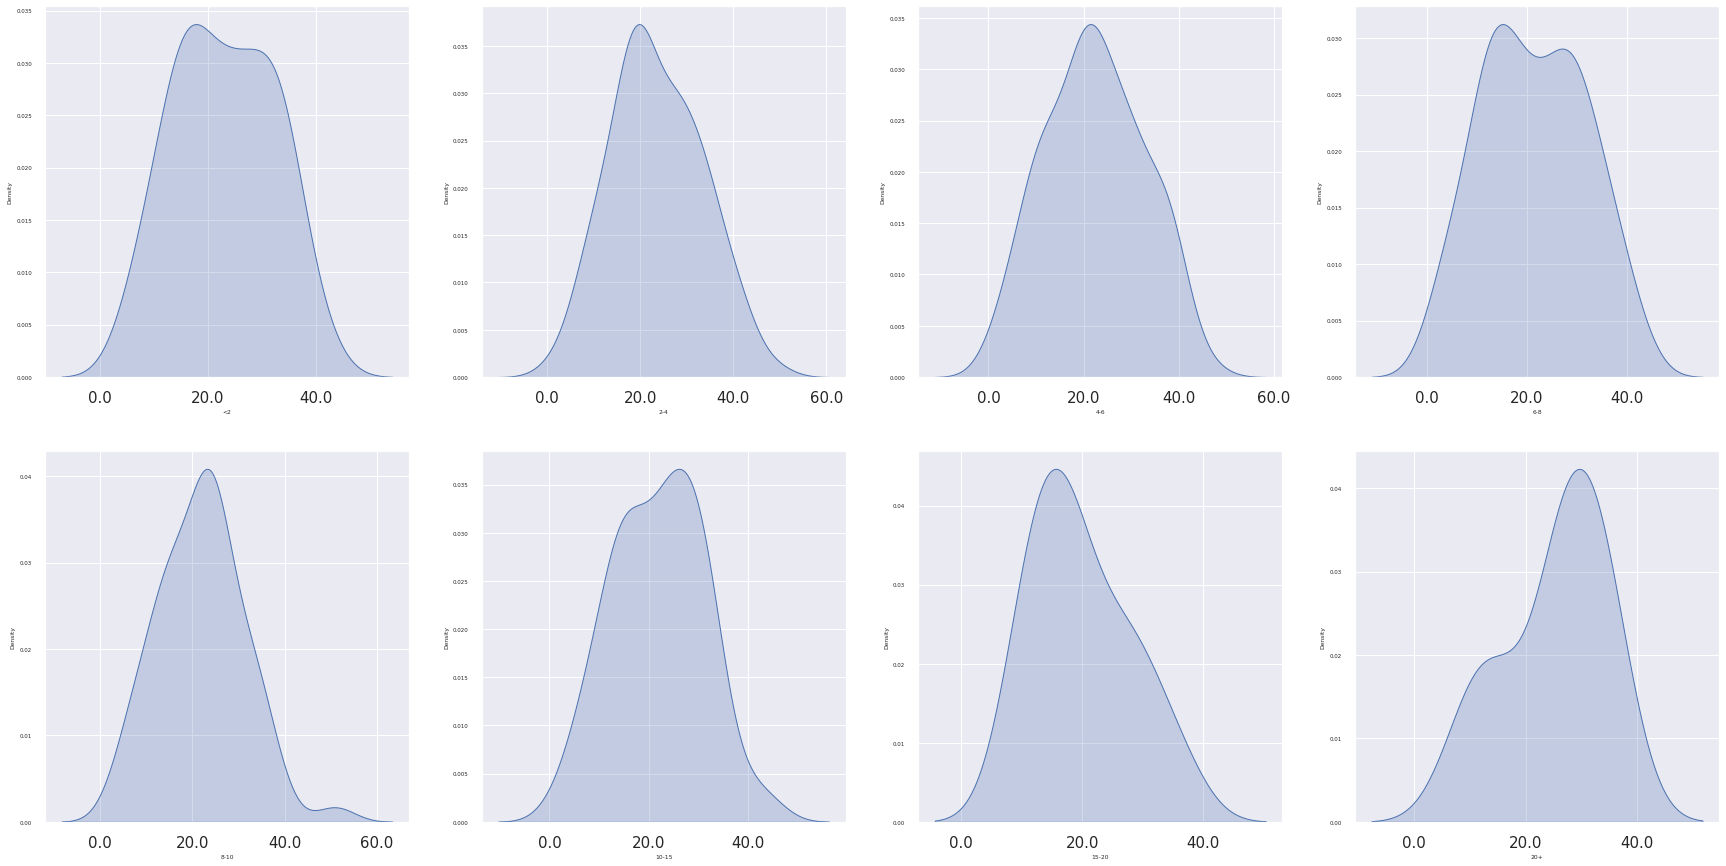

In [92]:
labels=['<2','2-4','4-6','6-8','8-10','10-15','15-20','20+']
fig,axis = plt.subplots(2,4,figsize=[30,15])
for i,label in enumerate(labels):
  sns.kdeplot(data=profiles_df.groupby('Experience_bucket')['Score'].get_group(label),ax=axis[int(i/4),i%4],fill=True)
  sns.set(font_scale=2)
  axis[int(i/4),i%4].set_xticklabels(axis[int(i/4),i%4].get_xticks(), size = 15)
  axis[int(i/4),i%4].set_xlabel(label)

### Boostrapped distribution for each experience bucket


In [93]:
import random

In [94]:
# Bucket_labels
scores_bootstrap_dict={}
for label in labels:
  scores_list = list(profiles_df.groupby('Experience_bucket')['Score'].get_group(label))
  scores_list_bootstrap = []
  for i in range(500):
    bootstrap_entry = []
    for j in range(len(scores_list)):
      bootstrap_select = scores_list[random.randint(0,len(scores_list)-1)]
      bootstrap_entry.append(bootstrap_select)
    scores_list_bootstrap.append(np.asarray(bootstrap_entry).mean())
  scores_bootstrap_dict[label]=scores_list_bootstrap

scores_df = pd.DataFrame(scores_bootstrap_dict)

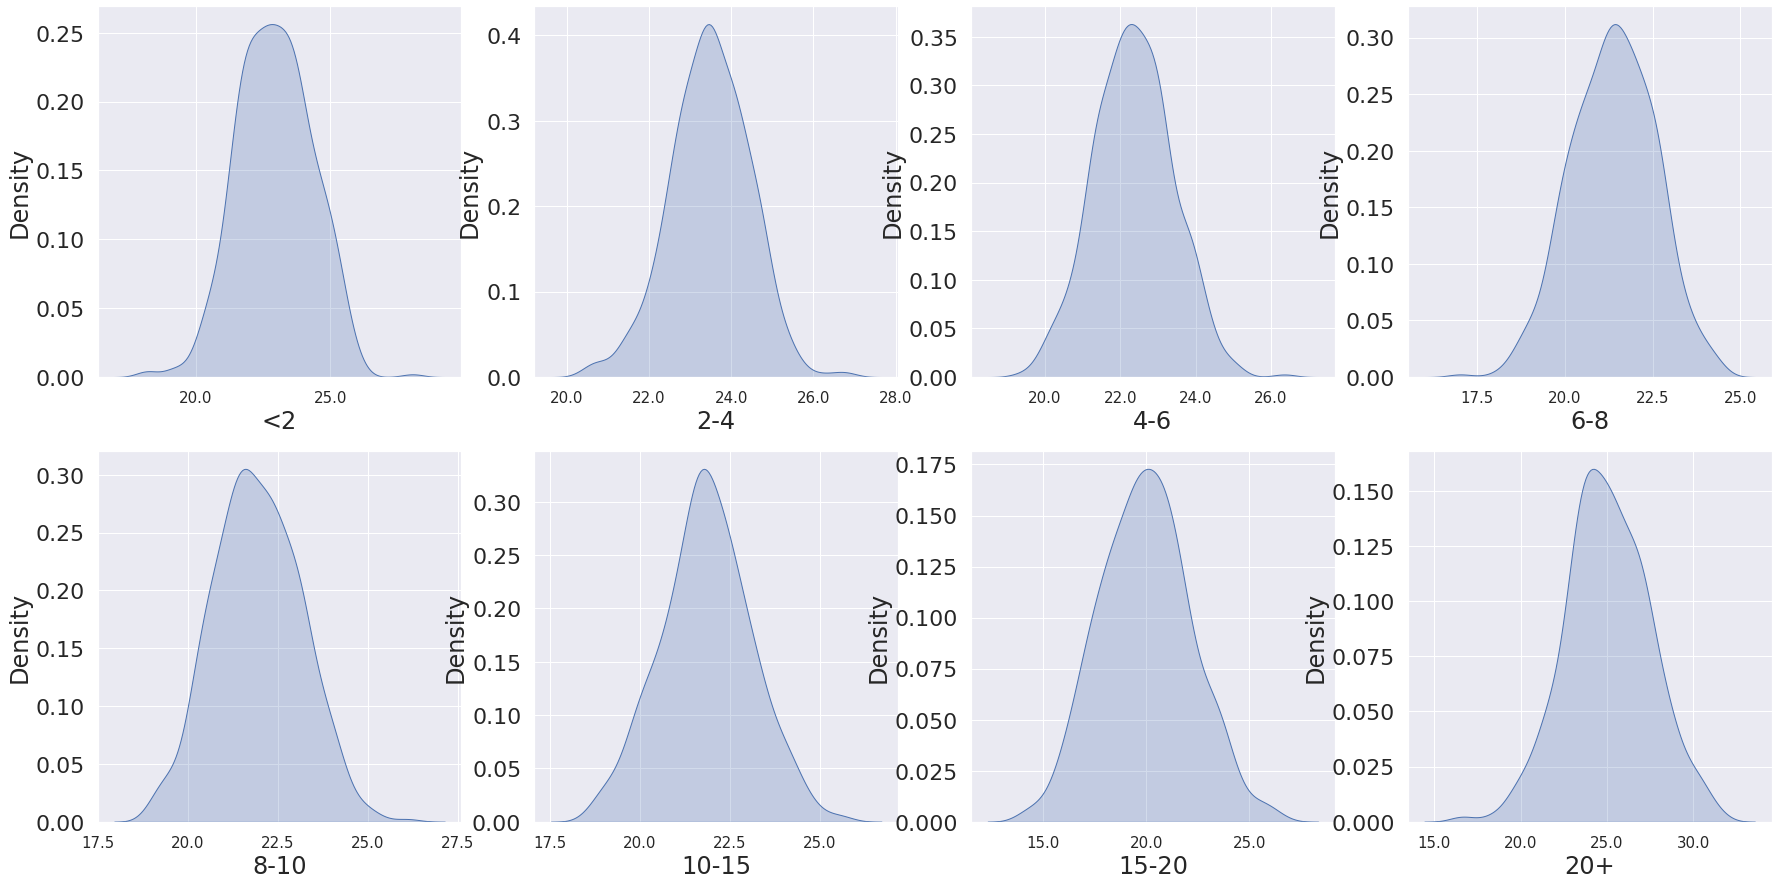

In [95]:
fig,axis = plt.subplots(2,4,figsize=[30,15])
for i,label in enumerate(labels):
  sns.kdeplot(data=scores_df,x=label,ax=axis[int(i/4),i%4],fill=True)
  axis[int(i/4),i%4].set_xticklabels(axis[int(i/4),i%4].get_xticks(), size = 15)

##User Profile Summary Genearator</br>

For a given user profile, we would like to generate a summary report that compares the user's Skill rating with other users.</br>

We will then generate a customised learning plan for the user that will help them upgrade their skills.



In [96]:
from scipy import stats
def calculate_precentile(arr,x):
  percentile = stats.percentileofscore(arr, x)
  return percentile

def profile_values(index):
  score = profiles_df.loc[index,'Score']
  experience = profiles_df.loc[index,'Experience_bucket']
  array = scores_df[experience]
  avg_rating = array.mean()
  return array,score,experience,avg_rating

def plot_dist(index,percentile):
  fig,ax = plt.subplots(1,1,figsize=(14,8))
  sns.kdeplot(data=scores_df,x=profiles_df.loc[index,'Experience_bucket'],fill=True,ax=ax)
  ax.axvline(x=profile_values(profile_index)[1],color = 'r',label='Your percentile rank: {} %'.format(percentile))
  ax.legend()
  ax.set_xlabel('Skill rating distribution of similar LinkedIn profiles ')
  ax.set_xticklabels(ax.get_xticks(), size = 15)

def summary_generator(profile_index):
  array,score,experience,avg_rating=profile_values(profile_index)
  percentile = calculate_precentile(array,score)
  plot_dist(profile_index,percentile)

  print('User Profile Summary:-')
  print('Skill rating   = {}'.format(score))
  print('Experience     = {} yrs'.format(experience))
  print('Users with similar experience have an average skill rating of {}.'.format(round(avg_rating,1)))  

def course_recommneder(profile_index):
  print('We recopmmend focusing on imporving the following skills: AI,ML,etc. ')
  print('We suggest taking these courses: IBM   ')
  

Input an index between 0-462 to select a user profile and generate report

User Profile Summary:-
Skill rating   = 20
Experience     = 10-15 yrs
Users with similar experience have an average skill rating of 21.8.


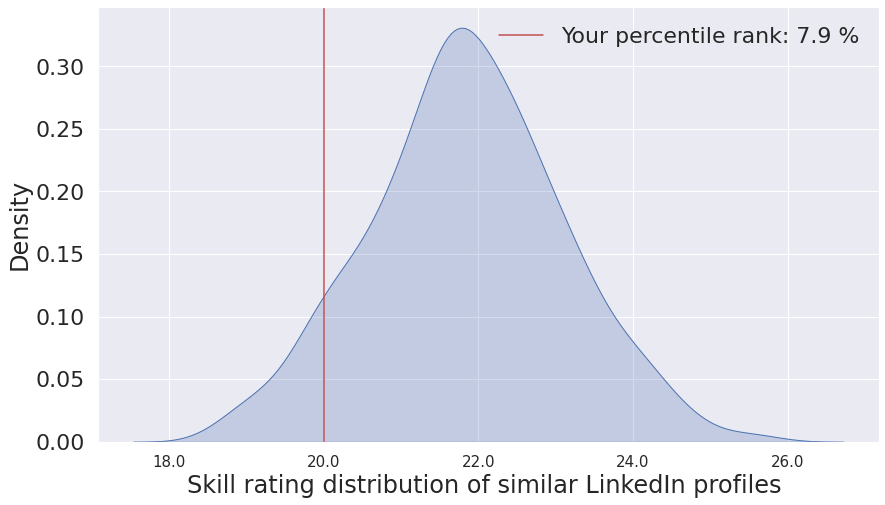

In [97]:
profile_index = 32

summary_generator(profile_index)

## Recommender Systems based on Collaborative Filtering

In [98]:
import pandas as pd
import numpy as np
import heapq
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances 
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline

Nowadays, recommender systems are used to personalise your experience on the web, telling you what to buy, where to eat or even who you should be friends with.

Two most ubiquitous types of recommender systems are **Content-Based** and **Collaborative Filtering (CF)**. Collaborative filtering produces recommendations based on the knowledge of users’ attitude to items, that is it uses the “wisdom of the crowd” to recommend items. In contrast, content-based recommender systems focus on the attributes of the items and give you recommendations based on the similarity between them.

CF can be divided into **Memory-Based Collaborative Filtering** and **Model-Based Collaborative filtering**. In this project, we will implement Memory-Based CF by computing cosine similarity. We use the 462 LinkedIn profile with their thechnical and soft skills along with their experience. We want to design a sysytem to recomend the skills and the corresponding courses based on the Memory-Based Collaborative Filtering. First, we read our data set which is 462 users and 85 most important skills among 2379 skills. Here is the code for selecting 85 important skills:

In [99]:
# Code for selecting the 85 most important skills
def remove_zeros(dataframe):
    zeros = []
    for i in range(0,dataframe.shape[1]):
        count = 0
        for x in range(0, dataframe.shape[0]):
            if (dataframe.iloc[x, i] == 0).all():
                count += 1   
        if count > (dataframe.shape[0]-27):
            zeros.append(i)
    dataframe = dataframe.drop(dataframe.columns[zeros], axis=1)
    return dataframe

In [101]:
ds_main = pd.read_csv(r"LinkedInUsers_Skills_main.csv")
ds = pd.read_csv(r"LinkedInUsers_Skills.csv")

Let's look at these dataframes before doing filtering:

In [102]:
ds = ds.drop(["User ID"], axis=1)
ds

,python,data modeling,statistical inference,google cloud platform,technology management,fice,debugging,logistic regression,database management,pandas,artificial intelligence,github,statistical analysis,communication,business intelligence,matplotlib,text mining,numpy,data manipulation,computer science,predictive analytics,reinforcement learning,cloud computing,nosql,innovation,data visualization,decision tree,algorithms,rstudio,data analysis,design thinking,chatbot,problem solving,apache hadoop,regression analysis,applied machine learning,business strategy,computer vision,risk management,multivariable calculus,...,trading,natural language processing,linear regression,neo4j,feature engineering,sql,linear algebra,management,statistics,mongodb,coding,deep learning,c 11,mapreduce,data management,leadership,apache spark,c,r,tensorflow,data processing,predictive modelling,analysis,project,computational neuroscience,data science,team building,graph theory,scikit learn,security,ficial analysis,markov chain monte carlo,classification algorithms,ficial engineering,data architecture,big data,knime,image segmentation,spark,analytics
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1
2,1,0,0,1,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
457,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
458,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
459,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
460,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [103]:
ds_main

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85
0,python,data modeling,statistical inference,google cloud platform,technology management,fice,debugging,logistic regression,database management,pandas,artificial intelligence,github,statistical analysis,communication,business intelligence,matplotlib,text mining,numpy,data manipulation,computer science,predictive analytics,reinforcement learning,cloud computing,nosql,innovation,data visualization,decision tree,algorithms,rstudio,data analysis,design thinking,chatbot,problem solving,apache hadoop,regression analysis,applied machine learning,business strategy,computer vision,risk management,multivariable calculus,...,trading,natural language processing,linear regression,neo4j,feature engineering,sql,linear algebra,management,statistics,mongodb,coding,deep learning,c 11,mapreduce,data management,leadership,apache spark,c,r,tensorflow,data processing,predictive modelling,analysis,project,computational neuroscience,data science,team building,graph theory,scikit learn,security,ficial analysis,markov chain monte carlo,classification algorithms,ficial engineering,data architecture,big data,knime,image segmentation,spark,analytics
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1
3,1,0,0,1,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
459,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
460,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
461,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


You can use the scikit-learn library to split the dataset into testing and training. model_selection.train_test_split shuffles and splits the data into two datasets according to the percentage of test examples (test_size) which in this problem is 0.20.

In [104]:
train_data, test_data = train_test_split(ds, test_size = 0.2)

### Memory-Based Collaborative Filtering
Memory-Based Collaborative Filtering approaches can be divided into two main sections: **user-item filtering** and **item-item filtering**. A user-item filtering will take a particular user, find users that are similar to that user based on similarity of their skills, and recommend skills that those similar users liked. In contrast, item-item filtering will take an item, find users who liked that item, and find other items that those users or similar users also liked. It takes items and outputs other items as recommendations.

In both cases, we need to create a user-item matrix which we build from the entire dataset.


In [105]:
#creat 2 user-item matrix, one for training and another for testing
train_data_matrix = train_data.to_numpy()[:,1:]
test_data_matrix = test_data.to_numpy()[:,1:]

For User-Item Collaborative Filtering the similarity values between users are measured by observing all the items that are rated by both users. A distance metric commonly used in recommender systems is **cosine similarity**, where the ratings are seen as vectors in n-dimensional space and the similarity is calculated based on the angle between these vectors. You can use the pairwise_distances function from sklearn to calculate the cosine similarity. Note, the output will range from 0 to 1 since the number in items are all non-negative.

Suppose A and B are 2 movie vectors, then the similarity between them can be calculated as:
$$sim(A,B) = cos(\theta) = \frac{A.B}{||A||.||B||}$$

Based on the cosine value, which ranges between -1 to 1,if its near 1 so they have positive relation , if -1 so negative and if 0 so no relation.

In [106]:
user_similarity = pairwise_distances(train_data_matrix, metric='cosine') #369*369 similarity matrix
item_similarity = pairwise_distances(train_data_matrix.T, metric='cosine') #85*85 similarity matrix

Next step is to make predictions. We have already created similarity matrices: user_similarity and item_similarity and therefore we can make a prediction by applying the following formula for user-based CF:

$$\hat{x}_{k, m} = \overline{x}_{k} + \frac{\sum_{u_a} sim_{u}(u_k, u_a)(x_{a,m} -x^{-}_{u_a})}{\sum_{u_a}|sim_{u}(u_k, u_a)|}$$ 

We can look at the similarity between users k and a as weights that are multiplied by the ratings of a similar user a (corrected for the average rating of that user).

When making a prediction for item-based CF we don’t need to correct for users average rating since query user itself is used to do predictions.

$$ \hat{x}_{k, m} = \frac{\sum_{i_b} sim_{i}(i_m, i_b)(x_{k,b})}{\sum_{i_b}|sim_{i}(i_m, i_b)|}$$
we can make a prediction by applying the following codes for both user and item similarity.

In [107]:
def predict(ratings, similarity, type='user'):
    
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        #We use np.newaxis so that mean_user_rating has same format as ratings
        
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    
    return pred

In [108]:
user_prediction = predict(train_data_matrix, user_similarity, type='user')
item_prediction = predict(train_data_matrix, item_similarity, type='item')

Let's look at them:

In [109]:
print("User prediction matrix is : \n", user_prediction, "\n")
print("Item prediction matrix is : \n", item_prediction)

User prediction matrix is : 
 [[-0.02329193 -0.08850932 -0.05861801 ... -0.10209627  0.02290373
   0.28920807]
 [ 0.13630186  0.06949492  0.09960168 ...  0.05595908  0.1813928
   0.40495757]
 [ 0.07074345  0.0119647   0.04075016 ... -0.00227189  0.12249299
   0.32299303]
 ...
 [ 0.01031057 -0.03887053 -0.00758734 ... -0.05160828  0.07859849
   0.28511282]
 [ 0.08533511  0.0213158   0.05217255 ...  0.00800327  0.13843891
   0.35677759]
 [ 0.11031534  0.04746039  0.07734402 ...  0.0343168   0.15873677
   0.37943865]] 

Item prediction matrix is : 
 [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.15431238 0.15384112 0.15302772 ... 0.1523921  0.15076008 0.12532673]
 [0.08311146 0.09304278 0.08916919 ... 0.09568071 0.0845215  0.05389512]
 ...
 [0.03145241 0.04538133 0.04510495 ... 0.04776104 0.04487633 0.02718535]
 [0.09712952 0.10277419 0.10114581 ... 0.10508006 0.0985553  0.07265535]
 [0.11538001 0.12606337 0.12011391 ... 0.13036642 0.11420978 0.08478522]]


Now we select the 3 most important skills(3 large number in the each row of above matrices) which we can recommend the users base on the item-user collaborative filtering method.

### Recommending skills based on user:


In [110]:
Skills = []
for i in range (train_data_matrix.shape[0]):    
    Skills.append(heapq.nlargest(3, range(train_data_matrix.shape[1]), user_prediction[i].take))

print("Our index skill recommender based on user is: ",Skills)   


Our index skill recommender based on user is:  [[66, 49, 28], [66, 49, 28], [66, 49, 28], [66, 49, 62], [66, 49, 28], [66, 49, 28], [66, 49, 28], [66, 49, 62], [66, 49, 62], [66, 49, 62], [66, 49, 28], [66, 49, 28], [66, 49, 28], [66, 49, 39], [66, 49, 28], [66, 49, 28], [66, 49, 28], [66, 49, 28], [66, 49, 62], [66, 49, 28], [66, 49, 28], [66, 49, 62], [66, 49, 28], [66, 49, 28], [66, 49, 28], [66, 49, 28], [66, 49, 28], [66, 49, 28], [66, 49, 62], [66, 49, 28], [66, 49, 62], [66, 49, 28], [66, 49, 62], [66, 49, 28], [66, 49, 62], [66, 49, 62], [66, 49, 28], [66, 49, 28], [66, 49, 28], [66, 49, 62], [66, 49, 28], [66, 49, 28], [66, 49, 28], [66, 49, 62], [66, 49, 28], [66, 49, 28], [66, 49, 62], [66, 49, 28], [66, 49, 28], [66, 49, 28], [66, 49, 62], [66, 49, 28], [66, 49, 62], [66, 49, 62], [66, 49, 62], [66, 49, 62], [66, 49, 39], [66, 49, 28], [66, 49, 28], [66, 49, 62], [66, 49, 28], [66, 49, 28], [66, 49, 62], [66, 49, 62], [66, 49, 62], [66, 49, 62], [66, 49, 28], [66, 49, 28], 

In [111]:
for i in range(len(Skills)):
    B = []
    for j in range(3):
        B.append(ds_main.iloc[0][Skills[i][j]])
    print("We recomend {} skills to user {}. \n ".format(B, i))
        

We recomend ['predictive modelling', 'feature engineering', 'rstudio'] skills to user 0. 
 
We recomend ['predictive modelling', 'feature engineering', 'rstudio'] skills to user 1. 
 
We recomend ['predictive modelling', 'feature engineering', 'rstudio'] skills to user 2. 
 
We recomend ['predictive modelling', 'feature engineering', 'c'] skills to user 3. 
 
We recomend ['predictive modelling', 'feature engineering', 'rstudio'] skills to user 4. 
 
We recomend ['predictive modelling', 'feature engineering', 'rstudio'] skills to user 5. 
 
We recomend ['predictive modelling', 'feature engineering', 'rstudio'] skills to user 6. 
 
We recomend ['predictive modelling', 'feature engineering', 'c'] skills to user 7. 
 
We recomend ['predictive modelling', 'feature engineering', 'c'] skills to user 8. 
 
We recomend ['predictive modelling', 'feature engineering', 'c'] skills to user 9. 
 
We recomend ['predictive modelling', 'feature engineering', 'rstudio'] skills to user 10. 
 
We recomend



 ### Recommending skills based on item:

In [112]:
Skills = []
for i in range (train_data_matrix.shape[0]):    
    Skills.append(heapq.nlargest(3, range(train_data_matrix.shape[1]), item_prediction[i].take))

print("Our index skill recommender based on user is: ",Skills)   


Our index skill recommender based on user is:  [[0, 1, 2], [35, 23, 56], [23, 56, 7], [23, 56, 38], [23, 56, 38], [7, 76, 47], [7, 76, 11], [23, 56, 34], [38, 23, 56], [23, 56, 34], [14, 43, 32], [7, 76, 47], [38, 34, 65], [23, 56, 7], [38, 23, 56], [7, 76, 25], [7, 76, 11], [7, 76, 47], [7, 76, 47], [7, 76, 23], [7, 76, 23], [7, 76, 43], [23, 56, 80], [23, 56, 7], [7, 76, 47], [71, 43, 7], [7, 76, 80], [34, 23, 56], [54, 25, 38], [71, 1, 23], [23, 56, 7], [7, 76, 11], [23, 56, 47], [23, 56, 3], [7, 76, 23], [23, 56, 7], [38, 43, 71], [7, 76, 23], [7, 76, 47], [23, 56, 38], [7, 76, 80], [7, 76, 23], [7, 76, 47], [38, 3, 17], [7, 76, 11], [7, 76, 47], [7, 76, 54], [23, 56, 38], [7, 76, 47], [6, 46, 7], [7, 76, 47], [23, 56, 3], [7, 76, 47], [47, 7, 76], [7, 76, 23], [23, 56, 34], [23, 56, 3], [7, 76, 47], [7, 76, 47], [7, 76, 47], [7, 76, 11], [23, 56, 38], [7, 76, 11], [23, 56, 7], [23, 56, 5], [7, 76, 34], [38, 71, 43], [38, 71, 3], [7, 76, 64], [7, 76, 47], [38, 43, 50], [7, 76, 30],

In [113]:
for i in range(len(Skills)):
    B = []
    for j in range(3):
        B.append(ds_main.iloc[0][Skills[i][j]])
    print("We recomend {} skills to user {}. \n ".format(B, i))
        

We recomend ['python', 'data modeling', 'statistical inference'] skills to user 0. 
 
We recomend ['applied machine learning', 'nosql', 'deep learning'] skills to user 1. 
 
We recomend ['nosql', 'deep learning', 'logistic regression'] skills to user 2. 
 
We recomend ['nosql', 'deep learning', 'risk management'] skills to user 3. 
 
We recomend ['nosql', 'deep learning', 'risk management'] skills to user 4. 
 
We recomend ['logistic regression', 'markov chain monte carlo', 'linear regression'] skills to user 5. 
 
We recomend ['logistic regression', 'markov chain monte carlo', 'github'] skills to user 6. 
 
We recomend ['nosql', 'deep learning', 'regression analysis'] skills to user 7. 
 
We recomend ['risk management', 'nosql', 'deep learning'] skills to user 8. 
 
We recomend ['nosql', 'deep learning', 'regression analysis'] skills to user 9. 
 
We recomend ['business intelligence', 'strategy', 'problem solving'] skills to user 10. 
 
We recomend ['logistic regression', 'markov chai

### Evaluation

There are many evaluation metrics but one of the most popular metric used to evaluate accuracy of predicted items in recommending systems is **Root Mean Squared Error (RMSE)**.

$$RMSE  = \sqrt{\frac{1}{N} \sum{(x_i -\hat{x}_i)^2}}$$

Since we only want to consider predicted ratings that are in the test dataset, we filter out all other elements in the prediction matrix with prediction[ground_truth.nonzero()].

In [114]:
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten()
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return np.sqrt(mean_squared_error(prediction, ground_truth))

In [115]:
print("User-based CF RMSE: " + str(rmse(user_prediction, test_data_matrix)))
print("Item-based CF RMSE: " + str(rmse(item_prediction, test_data_matrix)))

User-based CF RMSE: 0.7085574081289879
Item-based CF RMSE: 0.9139258788368396


## Recommnding relevant courses to users according to recommended skills  

In this part, we want to recommend usefull courses to the users based on their recommeded skills in the previous part for both item-based and user-based. First, I load our Courses-Skills data set which we derived and drop some rows which have the same names and values(duplicated rows):



In [116]:
ds_course = pd.read_csv(r"Coureses_Skills.csv")
ds_course = ds_course.drop_duplicates(subset='Course Name', keep='first')
ds_course

,Index,Course Name,Description,URL,python,data modeling,statistical inference,google cloud platform,technology management,fice,debugging,logistic regression,database management,pandas,artificial intelligence,github,statistical analysis,communication,business intelligence,matplotlib,text mining,numpy,data manipulation,computer science,predictive analytics,reinforcement learning,cloud computing,nosql,innovation,data visualization,decision tree,algorithms,rstudio,data analysis,design thinking,chatbot,problem solving,apache hadoop,regression analysis,applied machine learning,...,trading,natural language processing,linear regression,neo4j,feature engineering,sql,linear algebra,management,statistics,mongodb,coding,deep learning,c 11,mapreduce,data management,leadership,apache spark,c,r,tensorflow,data processing,predictive modelling,analysis,project,computational neuroscience,data science,team building,graph theory,scikit learn,security,ficial analysis,markov chain monte carlo,classification algorithms,ficial engineering,data architecture,big data,knime,image segmentation,spark,analytics
0,0,IBM AI Engineering Professional Certificate,"Artificial intelligence (AI) is revolutionizing entire industries, changing the way companies ac...",https://www.coursera.org/professional-certificates/ai-engineer,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0
1,1,Mathematics for Machine Learning Specialization,"For a lot of higher level courses in Machine Learning and Data Science, you find you need to fre...",https://www.coursera.org/specializations/mathematics-machine-learning,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,Machine Learning for All,"Machine Learning, often called Artificial Intelligence or AI, is one of the most exciting areas ...",https://www.coursera.org/learn/uol-machine-learning-for-all,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,IBM Data Science Professional Certificate,"Data science is one of the hottest professions of the decade, and the demand for data scientists...",https://www.coursera.org/professional-certificates/ibm-data-science,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,Mind and Machine Specialization,This specialization examines the ways in which our current understanding of human thinking is bo...,https://www.coursera.org/specializations/mind-machine,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,209,Coding for Everyone: C and C++ Specialization,"This Specialization is intended for all programming enthusiasts, as well as beginners, computer ...",https://www.coursera.org/specializations/coding-for-everyone,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
220,220,Introduction to Clinical Data,This course introduces you to a framework for successful and ethical medical data mining. We wil...,https://www.coursera.org/learn/introduction-clinical-data,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
221,221,Introduction to Portfolio 

First, we defined a function which takes in courses list dataframe and recommended skills and output list of the courses that have the desired each skills, respectively:

In [117]:
def get_courses(data,skill):
    course_list = data.groupby(skill)['Course Name'].get_group(1)
    return course_list

### Recommending courses base on user matrix



In [118]:
Skills = []
for i in range (train_data_matrix.shape[0]):    
    Skills.append(heapq.nlargest(3, range(train_data_matrix.shape[1]), user_prediction[i].take))

for i in range(len(Skills)):
    B = []
    C = []
    for j in range(3):
        B.append(ds_main.iloc[0][Skills[i][j]])
        C.append(get_courses(ds_course,ds_main.iloc[0][Skills[i][j]]).values.tolist())
    print("We recomend {} courses to user {} for increasing {} skills, resepectively. \n ".format(C,i,B))

We recomend [['Machine Learning and Reinforcement Learning in Finance Specialization', 'Ethics in the Age of AI Specialization'], ['Machine Learning with TensorFlow on Google Cloud Platform Specialization', 'IBM Machine Learning Professional Certificate', 'Machine Learning with TensorFlow on Google Cloud Platform em PortuguÃªs Brasileiro Specialization'], ['Data Science Specialization']] courses to user 0 for increasing ['predictive modelling', 'feature engineering', 'rstudio'] skills, resepectively. 
 
We recomend [['Machine Learning and Reinforcement Learning in Finance Specialization', 'Ethics in the Age of AI Specialization'], ['Machine Learning with TensorFlow on Google Cloud Platform Specialization', 'IBM Machine Learning Professional Certificate', 'Machine Learning with TensorFlow on Google Cloud Platform em PortuguÃªs Brasileiro Specialization'], ['Data Science Specialization']] courses to user 1 for increasing ['predictive modelling', 'feature engineering', 'rstudio'] skills, 

### Recommending courses base on item matrix


In [119]:
Skills = []
for i in range (train_data_matrix.shape[0]):    
    Skills.append(heapq.nlargest(3, range(train_data_matrix.shape[1]), item_prediction[i].take))

for i in range(len(Skills)):
    B = []
    C = []
    for j in range(3):
        B.append(ds_main.iloc[0][Skills[i][j]])
        C.append(get_courses(ds_course,ds_main.iloc[0][Skills[i][j]]).values.tolist())
    print("We recomend {} courses to user {} for increasing {} skills, resepectively. \n ".format(C,i,B))

We recomend [['IBM AI Engineering Professional Certificate', 'IBM Data Science Professional Certificate', 'Applied Data Science with Python Specialization', 'IBM Applied AI Professional Certificate', 'Deep Learning Specialization', 'Machine Learning Specialization', 'Machine Learning for Trading Specialization', 'Python for Data Science and AI', 'Computational Thinking for Problem Solving', 'IBM Machine Learning Professional Certificate', 'Investment Management with Python and Machine Learning Specialization', 'Applied Machine Learning in Python', 'Machine Learning Foundations: A Case Study Approach', 'Building AI Applications with Watson APIs', 'Machine Learning for Accounting with Python', 'AI Workflow: Machine Learning, Visual Recognition and NLP', 'Data for Machine Learning', 'AI Workflow: Business Priorities and Data Ingestion', 'Machine Learning Rapid Prototyping with IBM Watson Studio', 'Applied Data Science Specialization', 'Neural Networks and Deep Learning', 'Applied Plotting

In the real world, since there will be a lot of users, it will be really expensive and inefficient to compute the user similarity, hence item-based filtering is preferred, since the items are added /  removed at less rapid  pace and  the item similarity are also much more limited compared to user based.

#Appendix

##LinkedIn Jobs Web Scrapping

In [ ]:
"""
import re
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import nltk 
nltk.download('punkt')
from collections import Counter
from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import string
from collections import OrderedDict
import requests
from bs4 import BeautifulSoup

# dictionary with skills used to parse job descriptions, categories become columns in the resulting DataFrame
skills_keywords_dict = {
        # tech skills
        'Excel': ['Excel'],
        'Python': ['Python'],
        'R': ['R ', ' R ', 'R,', 'R/'], # 'R' surrounded by spaces and signs
        'Java': ['Java', 'JVM'],
        'Scala': ['Scala'],
        'C/C++': ['C/C++', 'C++', ' C '],   # 'C' surrounded by spaces and signs
        'MATLAB': ['MATLAB'],
        'SAS': ['SAS'],
        'SQL/databases': ['SQL', 'databases'],
        'Oracle':['Oracle'],
        'SPSS': ['SPSS'],
        'Stata': ['Stata'],
        'Machine Learning': ['Machine Learning', 'ML'],
        'Data Mining/Analytics': ['Data Mining', 'DM', 'Analytics'],
        'NLP': ['Natural Language Processing', 'NLP'],
        'Visualisation': ['Visualisation', 'Visualization'],
        'Big Data': ['Big Data', 'Spark', 'kafka', 'Hive',
                     'beam', 'Hadoop', 'MapReduce', 'Hbase',
                     'Coudera', 'Hortonworks'],
        'AWS Cloud': ['AWS'],
        'Probability': ['probablity', 'probability theory'],
        'Support Vector Machines': ['SVM', 'Support vector machines'],
        'Neural Networks': ['Neural Networks', 'ANN', 'MLP', 'CNN', 'Tensorflow', 'Keras', 'Theano'],
        'GCP': ['GCP'],
        'Jason': ['Jason'],
        'xml': ['xml'],
        'Azure': ['Azure'],
        'Google Cloud': ['Google Cloud'],
        'Mathematics': ['Mathematics'],
        'IBM': ['IBM'],
        'Algebra': ['Algebra'],
        'Statistics' :  ['Statistics'],
        'Operations research': ['Operations research'],
        'DevOps': ['DevOps', 'TDD', 'test-driven'],
        'Git':['GitHub', 'Git', 'version control'],
        # soft skills
        'presentation' : ['communication', 'presentation'],
        'management' : ['management', 'Data management'],
        'agile' : ['agile'],
        'SDLC' : ['SDLC', 'sdlc', 'software development', 'lifecycle'],
        'decision making' : ['decision making', 'decision analysis'],
        'problem solving': ['problem solving'],
        'Team building': ['Team leadership', 'team building'],
        'project_management': ['project management'],
        'leadership': ['leadership'],
        'consulting': ['consulting', 'consultant']
    }

    # 20 job postings per page
def get_urls_linkedin(url):
    # get html back
    html = requests.get(url)
    html = html.text
    soup = BeautifulSoup(html, 'lxml')

    # extract the number of search results
    nums = soup.find('h1').find('span').text
    nums = int(nums)

    # add the common part between all search pages
    base_url = 'https://ca.linkedin.com/jobs/data-scientist-jobs?position=1&pageNum='
    
    urls = []
    for i in range(0, nums, 25):
        urls.append(base_url + str(i))
    
    return urls, nums

url = "https://ca.linkedin.com/jobs/data-scientist-jobs"
urls,nums = get_urls_linkedin(url)

def get_job_links_info_linkedin(urls):
    
    dic = {}
    # loop over all page-urls
    for page_url in urls:

        # get the HTML of the search results page
        page = requests.get(page_url)
        content = page.text
        soup = BeautifulSoup(content, 'lxml')

        # find all <div> tags containing each job posting links and feed them to the function 'scrape_job_info'
        results = soup.find_all('a',{'class':"result-card__full-card-link"})

        for job in results:

            job_link = job['href']

            job_page = requests.get(job_link)
            job_content = job_page.text
            #soup_job = BeautifulSoup(job_content,'lxml')
            #job_desc = soup_job.find('div',{'class':"jobsearch-jobDescriptionText"}).get_text()
            dic[job_link] = job_content
            
    return dic
linkedin_dict = get_job_links_info_linkedin(urls)

def get_skills_from_job_linkedin(jobs_dict, skills_dict):
    
    results_dict = {} 
    
    # loop over all key(link)-value(HTML code) pairs in scraping results
    for link, job_html_text in jobs_dict.items():
        
    
        soup_job = BeautifulSoup(job_html_text, 'lxml')
        
        results_dict[link] = {} 
        
        # extract job title
        try:
            results_dict[link]['job_title'] = soup_job.find('h1',{'class':'topcard__title'}).text   
        except:
            results_dict[link]['job_title'] = 'Not found'
            
         # extract company name
        try:
            results_dict[link]['company_name'] = soup_job.find('a',{'class':'topcard__org-name-link topcard__flavor--black-link'}).text
        except:
            results_dict[link]['company_name'] = 'Not found'
                
        # search for the skills
        job_text = soup_job.text
        for skill_category, skills in skills_dict.items():
            
            category_found = 0  
            
            for skill in skills:        
                if job_text.find(skill) != -1: 
                    
                    category_found = 1
            
            results_dict[link][skill_category] = category_found 
    
    return results_dict 

results_dict = get_skills_from_job_linkedin(linkedin_dict, skills_keywords_dict)
df_linkedin = pd.DataFrame(results_dict).T.reset_index()

df_linkedin.to_csv('tech_linkedin.csv')
"""

##Coursera Data Science Corses Web Scrapping

In [ ]:
"""
# !pip3 install selenium
# !pip3 install webdriver_manager
import pandas as pd
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
import time

driver = webdriver.Chrome(ChromeDriverManager().install())

# 20 job postings per page
def get_urls(url):
    
    nums = 25
    # get html back
    html = requests.get(url)
    html = html.text
    soup = BeautifulSoup(html, 'lxml')

    # add the common part between all search pages
    base_url = 'https://www.coursera.org/search?query=artificial%20intelligence&indices%5Bprod_all_products_term_optimization%5D%5Bpage%5D=2&indices%5Bprod_all_products_term_optimization%5D%5Bconfigure%5D%5BclickAnalytics%5D=true&indices%5Bprod_all_products_term_optimization%5D%5Bconfigure%5D%5BruleContexts%5D%5B0%5D=en&indices%5Bprod_all_products_term_optimization%5D%5Bconfigure%5D%5BhitsPerPage%5D=10&configure%5BclickAnalytics%5D=true'
    urls = []
    urls.append(base_url)
    for i in range(2, nums):
        a = "https://www.coursera.org/search?query=artificial%20intelligence&indices%5Bprod_all_products_term_optimization%5D%5Bpage%5D="+str(i)+'&indices%5Bprod_all_products_term_optimization%5D%5Bconfigure%5D%5BclickAnalytics%5D=true&indices%5Bprod_all_products_term_optimization%5D%5Bconfigure%5D%5BruleContexts%5D%5B0%5D=en&indices%5Bprod_all_products_term_optimization%5D%5Bconfigure%5D%5BhitsPerPage%5D=10&configure%5BclickAnalytics%5D=true'
        urls.append(a)
        
    return urls

urls = get_urls('https://www.coursera.org/search?query=artificial%20intelligence&')

course_links, course_desc = [],[]
# loop over all page-urls
for page_url in urls:

    # get the HTML of the search results page
    page = requests.get(page_url)
    content = page.text
    soup = BeautifulSoup(content, 'lxml')

    results = soup.find_all('li',{'class':'ais-InfiniteHits-item'})

    for course in results:

        course_link = 'https://www.coursera.org' + course.find('a')['href']
        
        #description
        course = requests.get(course_link)
        course_soup = BeautifulSoup(course.text, 'lxml')
        try:
            desc = course_soup.find('div',{'class':'description'}).text
        except:
            desc = 'No Descriptions'
        course_desc.append(desc)
        
        course_links.append(course_link)
        
len(course_links)

#chapter links
i=0
course_names,chapter_names = [],[]
for link in course_links:
    
    page = requests.get(link)
    content = page.text
    soup = BeautifulSoup(content, 'lxml')
    
    course_names.append(soup.find('h1').text)
    i+=1
    print(i)
    #click buttons and generate full_link to further operations
    driver.get(link)
    time.sleep(5)
    try:
        button = driver.find_element_by_xpath('//*[@id="main"]/div/div[6]/div/div/div[2]/ul/li/div[2]/button/span')
        button.click()
        all_link = driver.page_source
    except:
        all_link = driver.page_source
    
    course_soup = BeautifulSoup(all_link, 'lxml')
    
    #course chapters names
    chapters = course_soup.find_all('h3',{'class':"headline-3-text bold m-t-1 m-b-2"})
    for i in chapters:
        chapter_names.append(i.text)

df_course = pd.DataFrame({'Course Names':course_names,'Course Descriptions':course_desc[0:225],'Course Link':course_links[0:225]})
df_course.to_csv('courses_ai.csv')
"""

##LinkedIN User Profiles Web Scraping

In [ ]:
# # imports
# from selenium import webdriver
# from selenium.webdriver.common.keys import Keys
# from parsel import Selector
# from bs4 import BeautifulSoup
# from bs4.element import Tag
# import csv
# import time
# import re
# import requests
# from selenium.webdriver.common.action_chains import ActionChains

# class parameters:

#     file_name = 'C:/Users/4khan/OneDrive/Desktop/01_Studies/01_Fall_2020/02_MIE_1624/Project/user_name_list.csv'
#     linkedin_username = '*******'
#     linkedin_password = '******' 
#     search_query = [#'site:linkedin.com/in/ AND "data scientist" AND "toronto"',
#                     #'site:linkedin.com/in/ AND "data scientist" AND "montreal"',
#                     # 'site:linkedin.com/in/ AND "data scientist" AND "ottawa"',
#                     #  'site:linkedin.com/in/ AND "data scientist" AND "vancouver"',
#                     #  'site:linkedin.com/in/ AND "data scientist" AND "new york"',
#                     #  'site:linkedin.com/in/ AND "data scientist" AND "san francisco"',
#                     #  'site:linkedin.com/in/ AND "data scientist" AND "seattle"',
#                     #  'site:linkedin.com/in/ AND "data scientist" AND "chicago"',
#                     #  'site:linkedin.com/in/ AND "data scientist" AND "houston"',
#                      'site:linkedin.com/in/ AND "data scientist" AND "los angeles"', 
#                      'site:linkedin.com/in/ AND "data scientist" AND "USA"',
#                      'site:linkedin.com/in/ AND "data scientist" AND "England"',
#                      'site:linkedin.com/in/ AND "data scientist" AND "Germany"',
#                      'site:linkedin.com/in/ AND "data scientist" AND "India"',
#                      'site:linkedin.com/in/ AND "data scientist" AND "Australia"',
#                      'site:linkedin.com/in/ AND "data scientist" AND "France"',
#                      'site:linkedin.com/in/ AND "data scientist" AND "China"',
#                      'site:linkedin.com/in/ AND "data scientist" AND "Japan"',
#                     ]

# # function to ensure all key data fields have a value
# def validate_field(field):
#     # if field is present pass 
#     if field:
#         pass
#     # if field is not present print text else:
#     else:
#        field = 'No results'
#     return field

# def main():

#     # specifies the path to the chromedriver.exe
#     driver = webdriver.Chrome('C:/Users/4khan/bin/chromedriver')

#     # driver.get method() will navigate to a page given by the URL address
#     driver.get('https://www.linkedin.com')

#     # locate email form by_class_name
#     username = driver.find_element_by_id('session_key')

#     # send_keys() to simulate key strokes
#     username.send_keys(parameters.linkedin_username)

#     # sleep for 0.5 seconds
#     time.sleep(0.5)

#     # locate password form by_class_name
#     password = driver.find_element_by_id('session_password')

#     # send_keys() to simulate key strokes
#     password.send_keys(parameters.linkedin_password)
#     time.sleep(0.5)

#     # locate submit button by_xpath
#     sign_in_button = driver.find_element_by_xpath('//*[@type="submit"]')

#     # .click() to mimic button click
#     sign_in_button.click()
#     linkedin_urls = []
#     for query in parameters.search_query:
#         driver.get('https:www.google.com')
#         time.sleep(3)

#         search_query = driver.find_element_by_name('q')
#         search_query.send_keys(query)
#         time.sleep(0.5)

#         search_query.send_keys(Keys.RETURN)
#         time.sleep(3)
#         linkedin_urls_list = driver.find_elements_by_xpath("//div[@class='g']//div[@class='rc']//div[@class='yuRUbf']//a[not(@class)]")
#         for url in linkedin_urls_list:
#             if "linkedin" in url.get_attribute("href"): 
#                 linkedin_urls.append(url.get_attribute("href")) 

#         time.sleep(0.5)
#     # For loop to iterate over each URL in the list
#     user_list = []
#     for linkedin_url in linkedin_urls:
#         #try:
#         user_list_iter =[]
#         # get the profile URL 
#         driver.get(linkedin_url)

#         # add a 5 second pause load\ing each URL
#         time.sleep(5)


#         try:
        
#             try:
#                 job_titles_sub = driver.find_elements_by_xpath("//ul[@class = 'pv-entity__position-group mt2']//li[@class = 'pv-entity__position-group-role-item']//div[@class='pv-entity__summary-info-v2 pv-entity__summary-info--background-section pv-entity__summary-info-margin-top ']//h3[@class = 't-14 t-black t-bold']")
#                 job_titles_sub = [ job_title.text for job_title in job_titles_sub]
#             except:
#                 job_titles_sub = []

#             job_titles = driver.find_elements_by_xpath("//li[@class = 'pv-entity__position-group-pager pv-profile-section__list-item ember-view']//div[@class='display-flex flex-column full-width']//h3[@class = 't-16 t-black t-bold']")
#             job_titles = [job_title.text for job_title in job_titles]

#             job_titles+=job_titles_sub
#             if len(job_titles)>4:
#                 job_titles = job_titles[0:4]

#             if len(job_titles)==0:
#                 print('Entered')
#                 scroll_tab = driver.find_element_by_xpath("//div[@class = 'pv-oc pv-occludable__background ember-view']")
#                 driver.execute_script("arguments[0].scrollIntoView();", scroll_tab)
#                 time.sleep(2)
#                 try:
#                     job_titles_sub = driver.find_elements_by_xpath("//ul[@class = 'pv-entity__position-group mt2']//li[@class = 'pv-entity__position-group-role-item']//div[@class='pv-entity__summary-info-v2 pv-entity__summary-info--background-section pv-entity__summary-info-margin-top ']//h3[@class = 't-14 t-black t-bold']")
#                     job_titles_sub = [ job_title.text for job_title in job_titles_sub]
#                 except:
#                     job_titles_sub = []

#                 job_titles = driver.find_elements_by_xpath("//li[@class = 'pv-entity__position-group-pager pv-profile-section__list-item ember-view']//div[@class='display-flex flex-column full-width']//h3[@class = 't-16 t-black t-bold']")
#                 job_titles = [job_title.text for job_title in job_titles]

#                 job_titles+=job_titles_sub
#                 if len(job_titles)>4:
#                     job_titles = job_titles[0:4]

#             try:
#                 job_exp_sub = driver.find_elements_by_xpath("//ul[@class = 'pv-entity__position-group mt2']//li[@class = 'pv-entity__position-group-role-item']//div[@class='pv-entity__summary-info-v2 pv-entity__summary-info--background-section pv-entity__summary-info-margin-top ']//h4[@class = 't-14 t-black--light t-normal']")
#                 job_exp_sub = [job_exp.text for job_exp in job_exp_sub]
#             except:
#                 job_exp_sub = []

#             job_experiences = driver.find_elements_by_xpath("//li[@class = 'pv-entity__position-group-pager pv-profile-section__list-item ember-view']//div[@class='display-flex flex-column full-width']//h4[@class = 't-14 t-black--light t-normal']")
#             job_experiences = [job_experience.text for job_experience in job_experiences]
            
#             job_experiences+=job_exp_sub

#             total_experience = 0
#             for job_experience in job_experiences:
#                 if 'yr' in job_experience:
#                     yrs_mos_str = job_experience.split('yr')
#                     yrs = re.sub("[^0-9]",'',yrs_mos_str[0])
#                     mons = re.sub("[^0-9]",'',yrs_mos_str[1])
#                     if len(mons)>0:
#                         experience = round(float(yrs)+float(mons)/12)
#                     else:
#                         experience = float(yrs)
#                 else:
#                     mons= re.sub("[^0-9]",'',job_experience)
#                     if len(mons)>0:
#                         experience = float(mons)/12
#                 total_experience += experience

        
#             schools = driver.find_elements_by_xpath("//li[@class = 'pv-profile-section__list-item pv-education-entity pv-profile-section__card-item ember-view']//div[@class='pv-entity__summary-info pv-entity__summary-info--background-section']//h3[@class = 'pv-entity__school-name t-16 t-black t-bold']")
#             schools = [school.text for school in schools]
#             if len(schools)>0:
#                 school = schools[0]
#             else:
#                 school = ' '

#             degrees_comp = driver.find_elements_by_xpath("//li[@class = 'pv-profile-section__list-item pv-education-entity pv-profile-section__card-item ember-view']//div[@class='pv-entity__summary-info pv-entity__summary-info--background-section']//span[@class = 'pv-entity__comma-item' ]")
#             degrees_comp = [degree.text for degree in degrees_comp]

#             if len(degrees_comp)>0:
#                 for i in range(0,len(degrees_comp),2):  
#                     degree=degrees_comp[i]
#                     try:
#                         major=degrees_comp[i+1]
#                     except:
#                         major = ' '
#             else:
#                 degree = ' '
#                 major = ' '

#             try:
#                 expand_button = driver.find_element_by_xpath("//button[@aria-controls = 'skill-categories-expanded']")
#             except:
#                 Skills_tab = driver.find_element_by_xpath("//div[@class = 'pv-deferred-area pv-deferred-area--pending pv-deferred-area--occluded ember-view']")
#                 driver.execute_script("arguments[0].scrollIntoView();", Skills_tab)
#                 time.sleep(2)
#                 expand_button = driver.find_element_by_xpath("//button[@aria-controls = 'skill-categories-expanded']")

#             # expand_button.click()
#             # skills = driver.find_elements_by_xpath("//ol[@class='pv-skill-category-list__skills_list list-style-none']//p[@class='pv-skill-category-entity__name tooltip-container']//span[@class='pv-skill-category-entity__name-text t-16 t-black t-bold']")
#             # skills = [skill.text for skill in skills]

#             if len(skills)>40:
#                 skills=skills[0:40]

#             for i,job in enumerate(job_titles[0:-1]):
#                 if i <5:
#                     user_list_iter.append(job)
#             if len(user_list_iter)<4:
#                 for i in range(4-len(user_list_iter)):
#                     user_list_iter.append(' ')

#             user_list_iter.append(total_experience)
#             user_list_iter.append(linkedin_url)
#             user_list_iter.append(school)
#             user_list_iter.append(degree)
#             user_list_iter.append(major)
#             for skill in skills:
#                 user_list_iter.append(skill)
            
            
            
#             user_list.append(user_list_iter)           
#         except:
#             print('skipping: {}'.format(linkedin_url))
#             continue

#     driver.quit()
#     # defining new variable passing two parameters
#     with open(parameters.file_name, 'w', newline = '') as file:
#         writer = csv.writer(file)
#         # writerow() method to the write to the file object
#         writer.writerow(['Job1', 'Job2', 'Job3', 'Job4', 'Experience','URL','school','Last degree','Major','Skills'])
#         writer.writerows(user_list)


##Coursera Course Skills Web Scraping

In [ ]:
# # function to ensure all key data fields have a value
# def validate_field(field):
#     # if field is present pass 
#     if field:
#         pass
#     # if field is not present print text else:
#     else:
#        field = 'No results'
#     return field

# def main():

#     # specifies the path to the chromedriver.exe
#     driver = webdriver.Chrome('C:/Users/4khan/bin/chromedriver')


#     with open(parameters.file_name,'r',encoding="utf-8") as courses:
#         reader = csv.reader(courses)
#         course_list = list(reader)

#     course_list.pop(0)
#     for course in course_list:
#         try:
#             if len(course[1])>0:
#                 driver.get(course[3])
#                 course_skills=driver.find_elements_by_xpath("//div[@class = '_t6niqc3']//span[@class = '_rsc0bd m-r-1s m-b-1s']//span[@class = '_x4x75x']")
#                 for skill in course_skills:
#                     course.append(skill.text)
#         except:
#             print('skipping {}'.format(course[3]))
#             continue
#     with open(parameters.file_name1,'w',encoding="utf-8",newline='') as courses:
#         writer = csv.writer(courses)
#         writer.writerow(['Index','Course Name','Description', 'URL', 'Skills']) 
#         writer.writerows(course_list)  